In [1]:
import sys, os, copy, re
import pandas as pd
import seaborn as sns
from scipy.optimize import newton, minimize, fsolve
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.patches
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
%matplotlib inline

In [2]:
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': False,
 'axes.spines.top': False
})
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [3]:
def approx_ratio_stats(a, b):
    # Making a lot of assumptions about normality
    # and no covariance estimate ratio stats:
    # https://chem.libretexts.org/Bookshelves/Analytical_Chemistry/Supplemental_Modules_(Analytical_Chemistry)/Quantifying_Nature/Significant_Digits/Propagation_of_Error
    # I think this is derived from the first term of a Taylor expansion of the real solution.
    a_mean, a_stdev = a
    b_mean, b_stdev = b
    ratio_mean = a_mean / b_mean
    ratio_stdev = ratio_mean * np.sqrt((a_stdev / a_mean)**2 + (b_stdev / b_mean)**2)
    return((ratio_mean, ratio_stdev))

In [4]:
def RR2Asp(RR):
    return(54.863* (RR**1.0646))
def RR2Asn(RR):
    return(60.033* (RR**0.9177))

In [5]:
### Read measurements
annotation_df = pd.read_excel('annotation_df.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('HT1080-WT_Antimycin_Asp-level_temporal3.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        if sum(metab_dict_mes[k]['ISTD Response']) != 0:
            metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['ISTD Response']
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = metab_dict_mes[k]['Sample ID']
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['dilution']
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'ISTD Response', 'Flag Details'], axis=1)

In [6]:
try:
    df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
except:
    df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']
    
    if 'Aspartate' in nam:
        df['Aspartate conc'] = RR2Asp(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['dilution'].values
    elif 'Asparagine' in nam:
        df['Asparagine conc'] = RR2Asn(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['dilution'].values

In [7]:
df['NAD-NADH'] = (df['NAD pos'] / df['NADH pos']).replace(np.inf, np.nan)
df['Pyr-Lac'] = (df['Pyruvate neg'] / df['Lactate neg']).replace(np.inf, np.nan)
df['IMP-AMP'] = (df['IMP pos'] / df['AMP pos']).replace(np.inf, np.nan)
df['GTP-ATP'] = (df['GTP pos'] / df['ATP pos']).replace(np.inf, np.nan)
df['GDP-ADP'] = (df['GDP pos'] / df['ADP pos']).replace(np.inf, np.nan)
df['GMP-AMP'] = (df['GMP pos'] / df['AMP pos']).replace(np.inf, np.nan)
df['GSH-GSSG'] = (df['Glutathione pos'] / df['Glutathione disulfide pos']).replace(np.inf, np.nan)
#df['DHAP-G3P'] = (df['DHAP neg'] / df['Glycerol 3-phosphate neg']).replace(np.inf, np.nan)

In [8]:
df_mean = df.groupby(['Time', 'Repeat', 'Rescue']).mean(numeric_only=True).reset_index()
df_stdev = df.groupby(['Time', 'Repeat', 'Rescue']).std(numeric_only=True).reset_index()

In [9]:
# Normalize data to time 0 #
col_exclude = ['Time', 'Sample ID', 'ISTD Amt', 'Replicate', 'dilution', 'Antimycin (uM)', 'Rescue', 'Repeat']

df_mean_norm = copy.deepcopy(df_mean)
df_stdev_norm = copy.deepcopy(df_stdev)

for idx in df_mean_norm.index.values:
    mask0 = (df_mean['Time'] == 0) & (df_mean['Repeat'] == df_mean_norm.loc[idx, 'Repeat']) & (df_mean['Rescue'] == df_mean_norm.loc[idx, 'Rescue'])
    norm_mean = list()
    norm_stdev = list()
    for colnam, val in zip(df_mean_norm.loc[idx,:].index.values, df_mean_norm.loc[idx,:].values):
        if colnam in col_exclude:
            norm_mean.append(df_mean_norm.loc[idx, colnam])
            norm_stdev.append(df_stdev_norm.loc[idx, colnam])
        else:
            a = (df_mean_norm.loc[idx, colnam], df_stdev_norm.loc[idx, colnam])
            b = (df_mean.loc[mask0, colnam].values[0], df_stdev.loc[mask0, colnam].values[0])
            ratio_mean, ratio_stdev = approx_ratio_stats(a, b)
            norm_mean.append(ratio_mean)
            norm_stdev.append(ratio_stdev)

    df_mean_norm.loc[idx,:] = norm_mean
    df_stdev_norm.loc[idx,:] = norm_stdev

<ipython-input-10-54ce3519a698>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(1, 1, figsize=(9, 4))


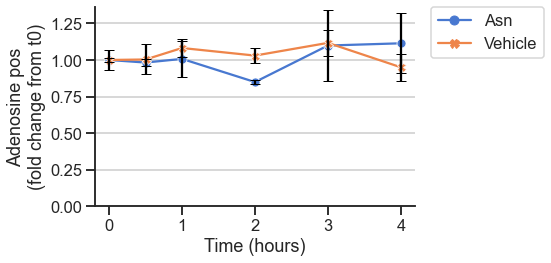

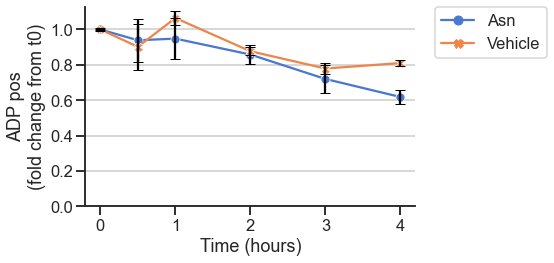

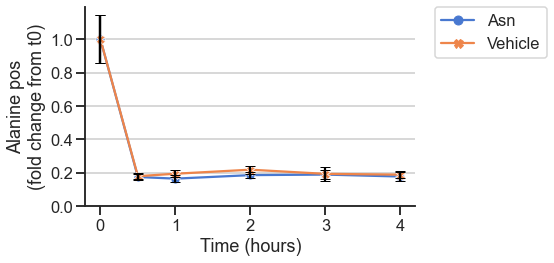

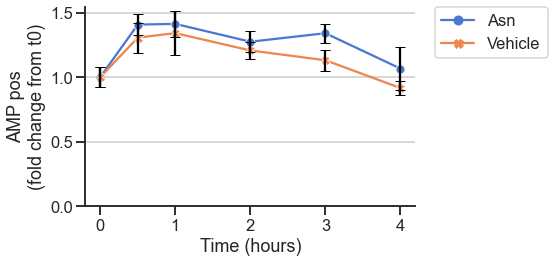

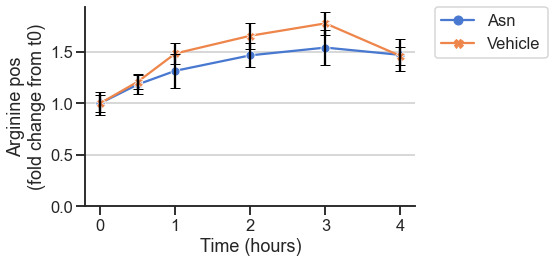

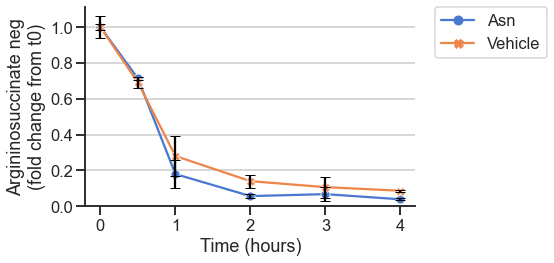

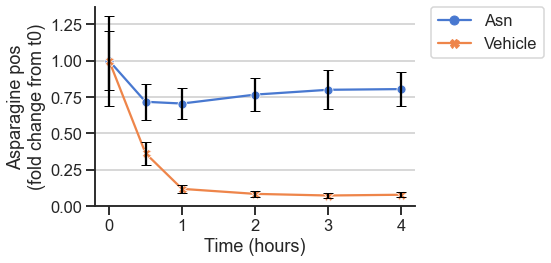

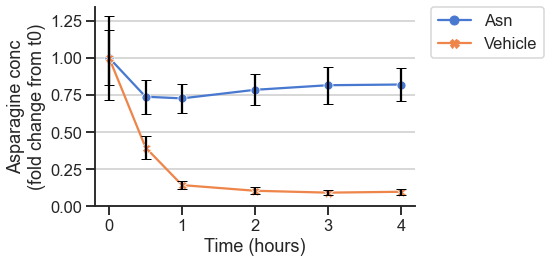

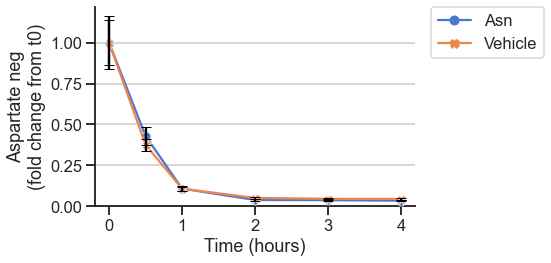

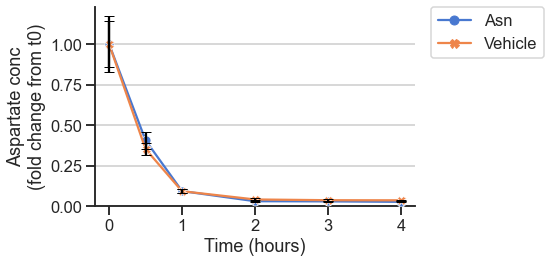

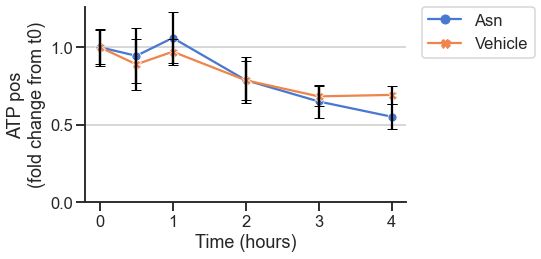

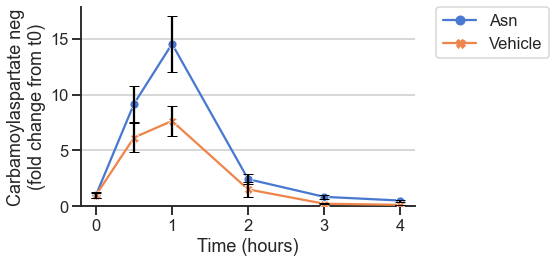

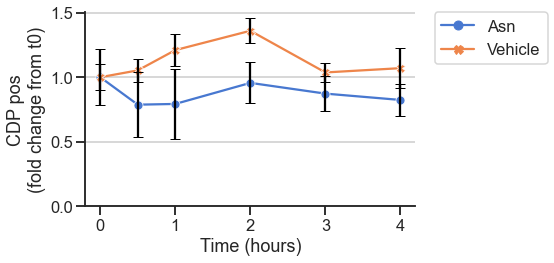

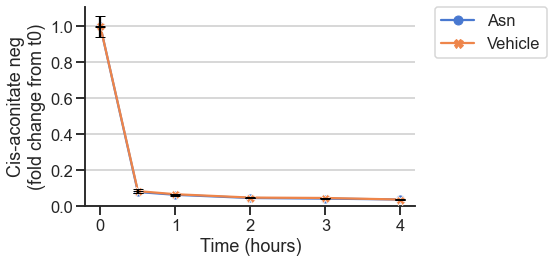

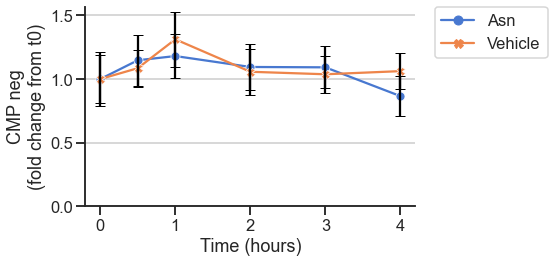

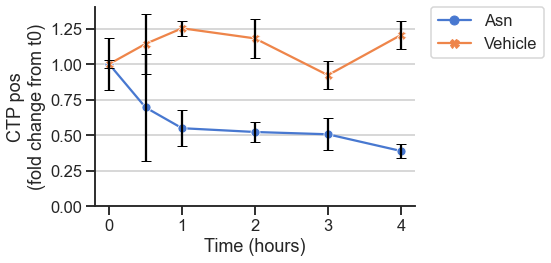

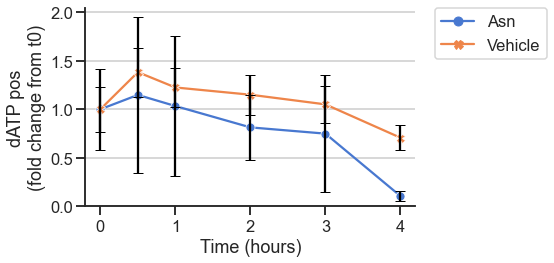

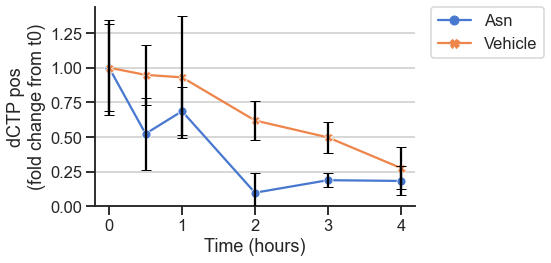

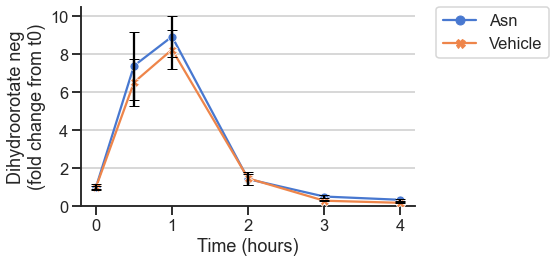

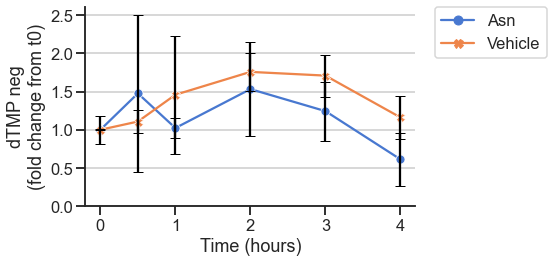

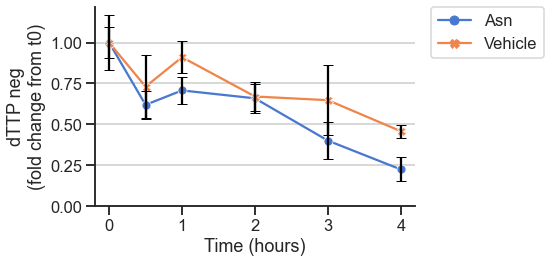

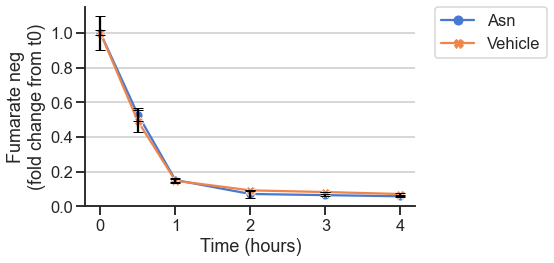

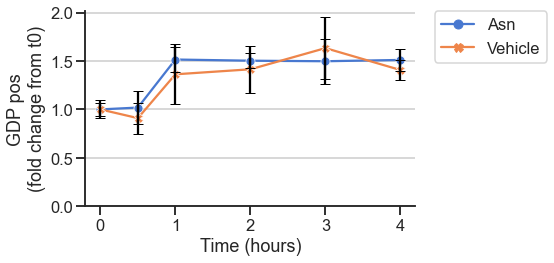

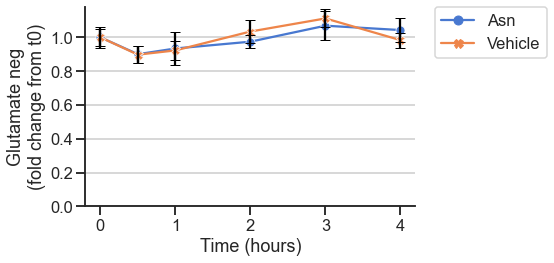

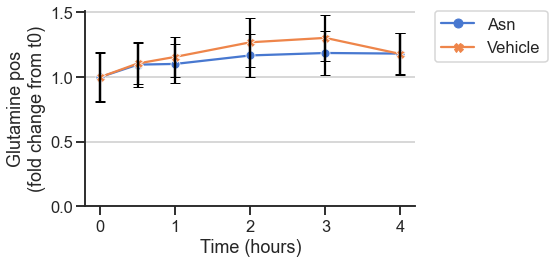

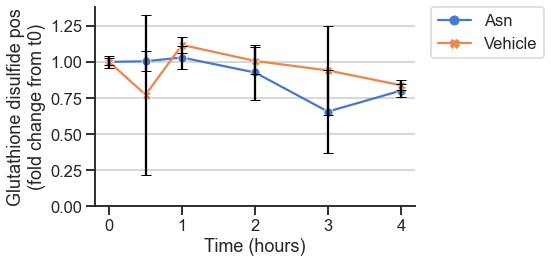

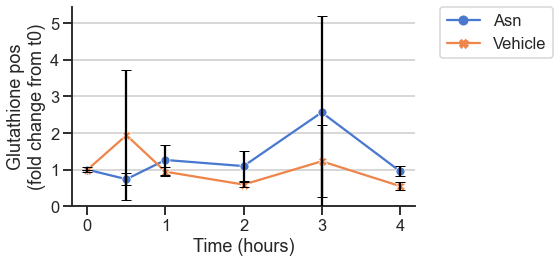

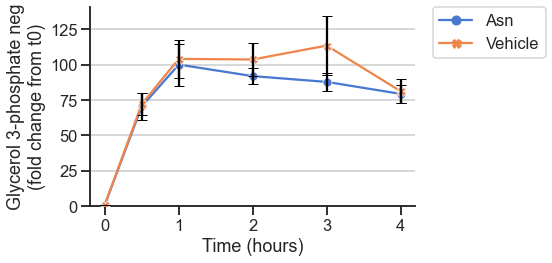

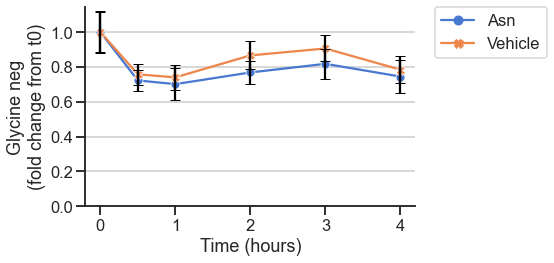

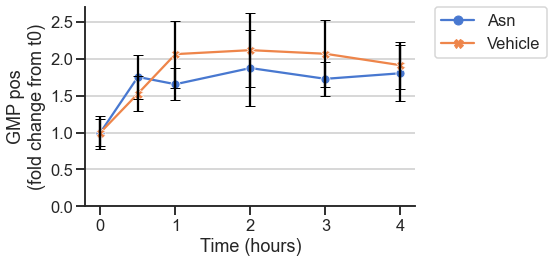

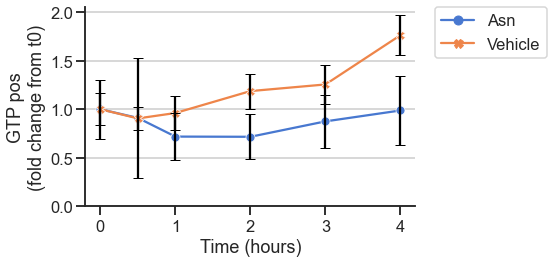

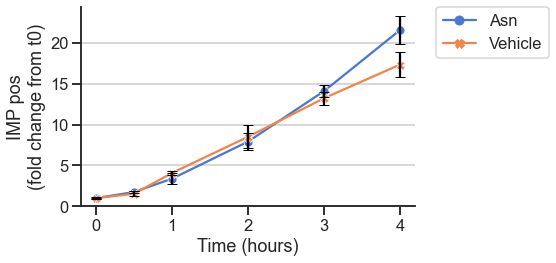

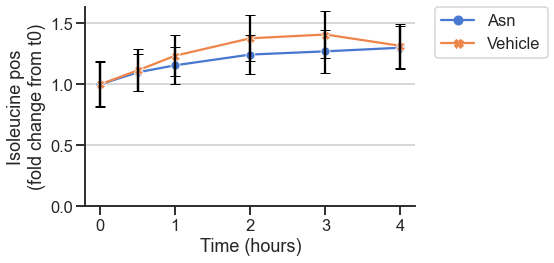

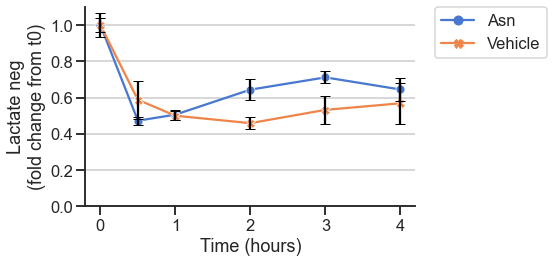

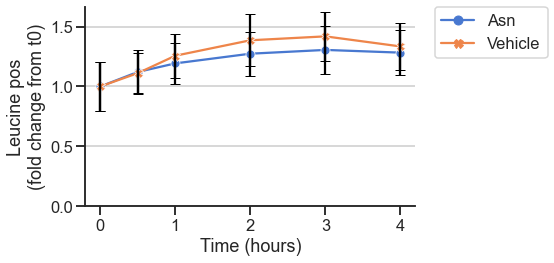

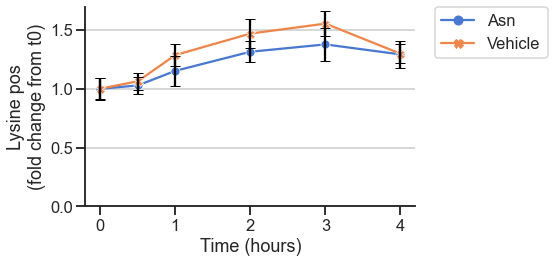

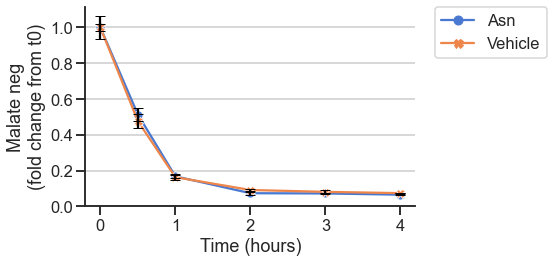

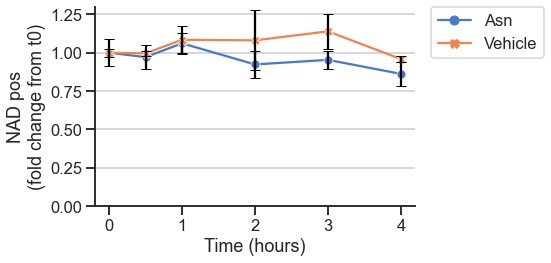

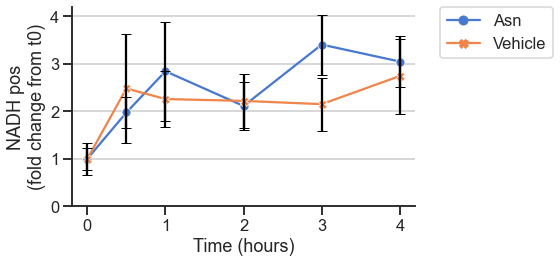

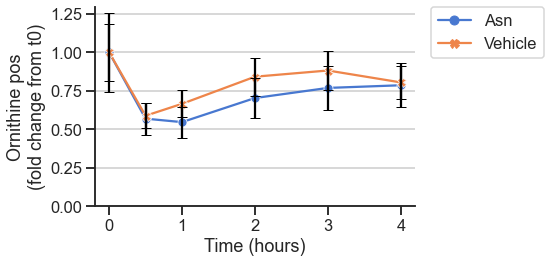

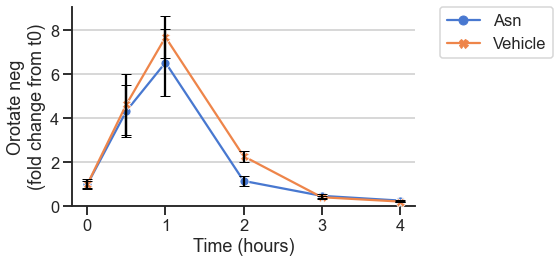

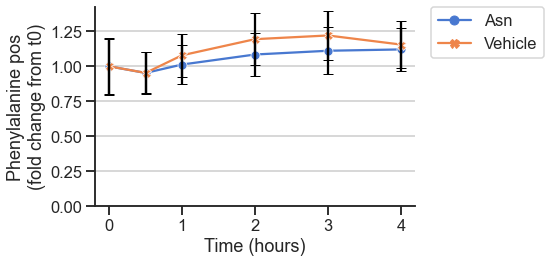

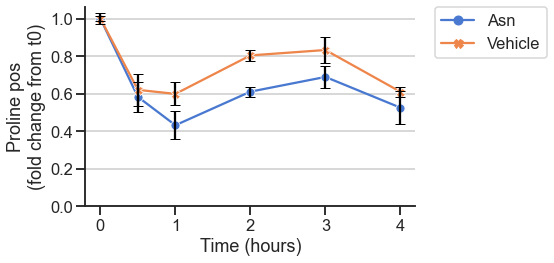

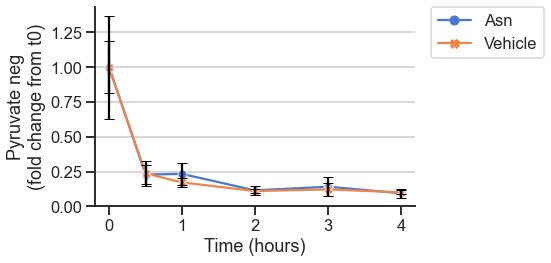

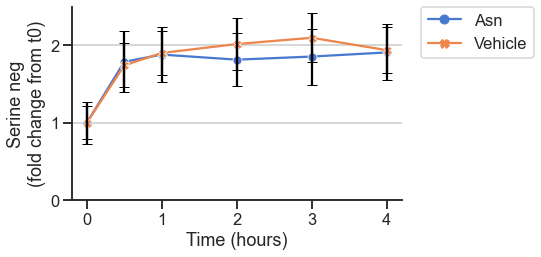

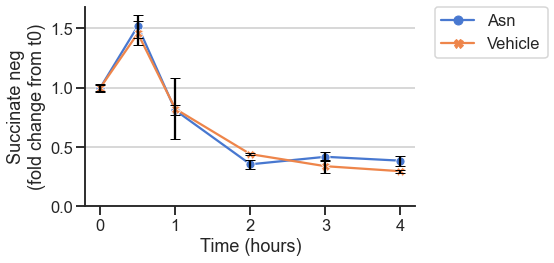

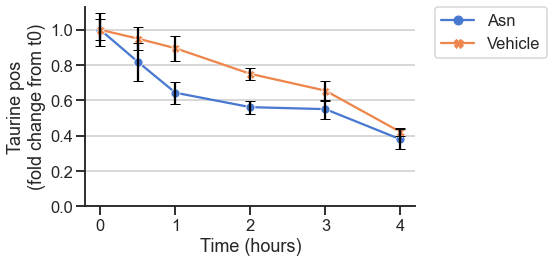

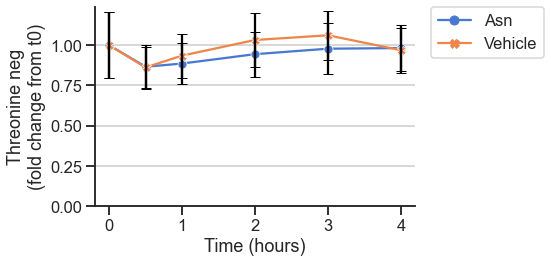

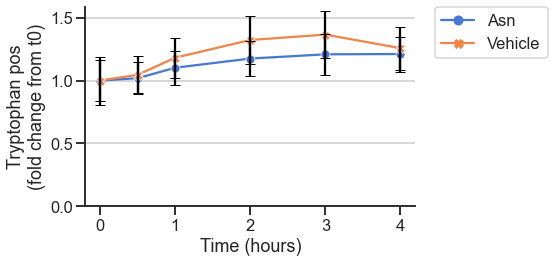

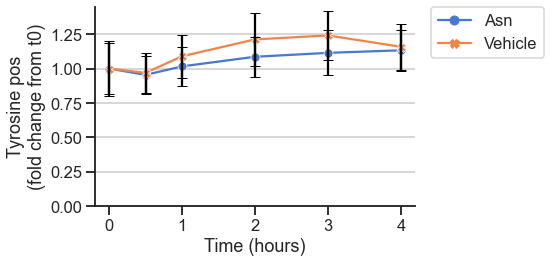

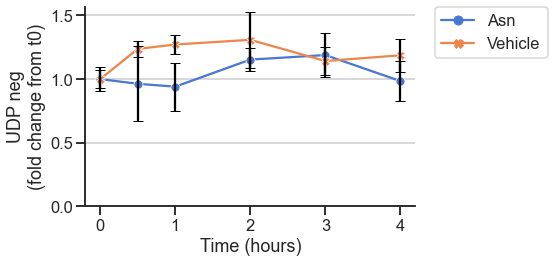

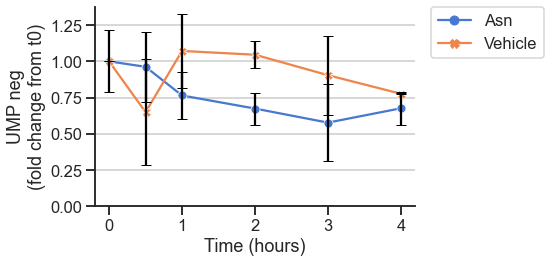

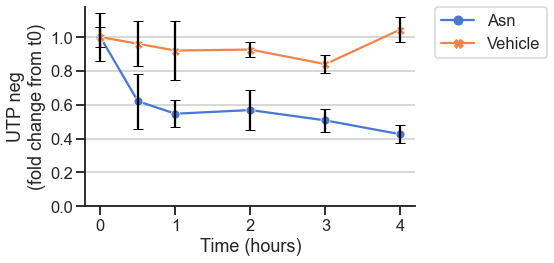

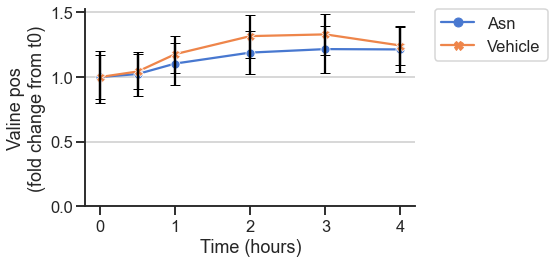

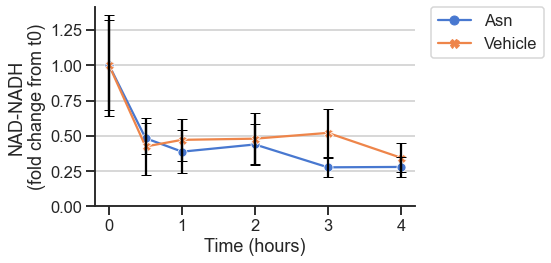

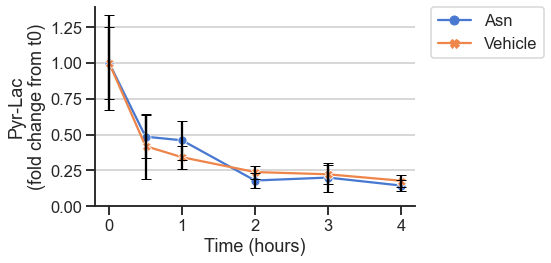

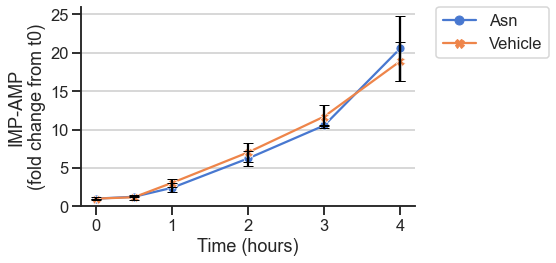

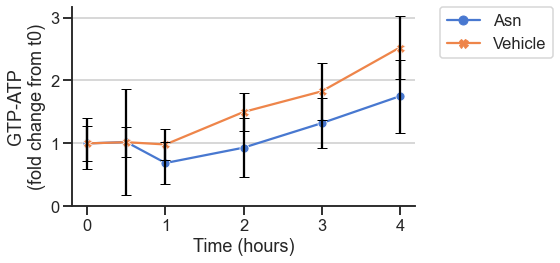

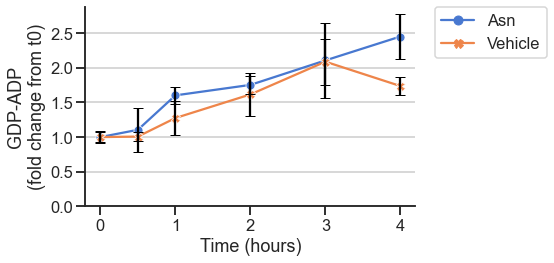

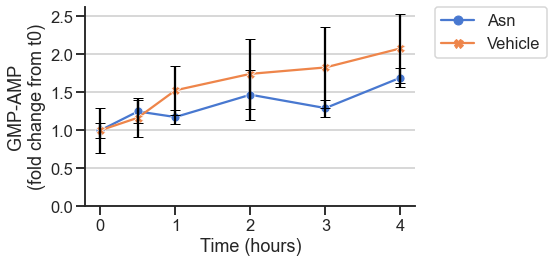

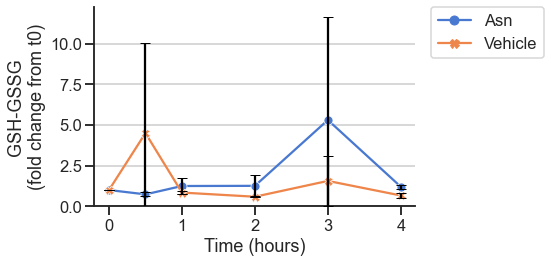

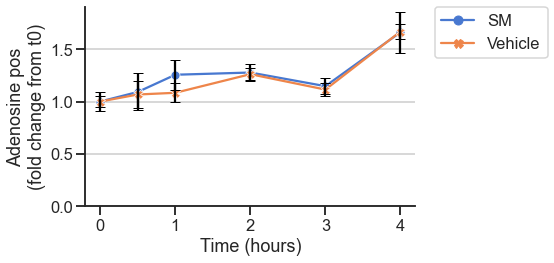

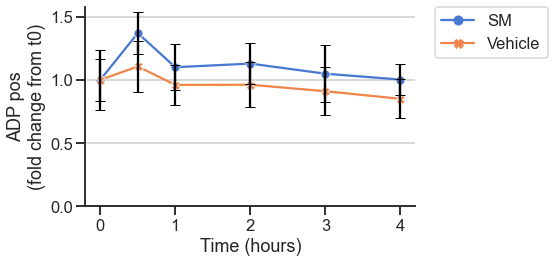

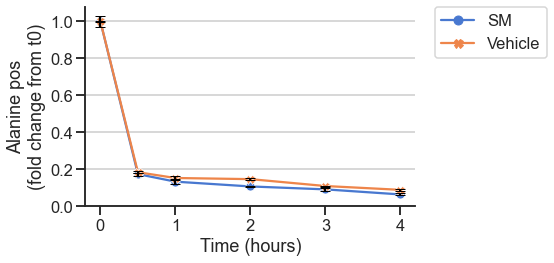

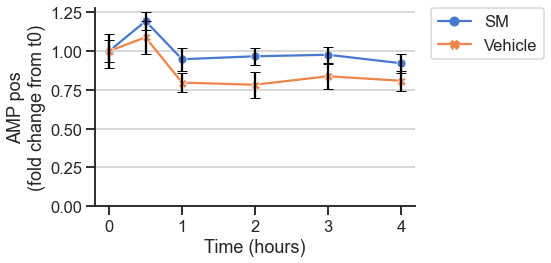

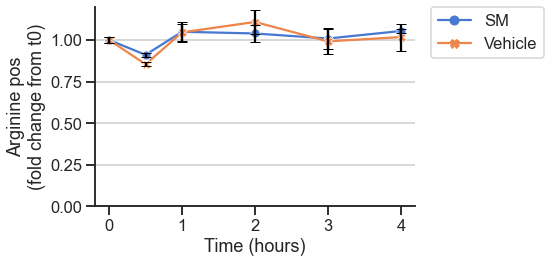

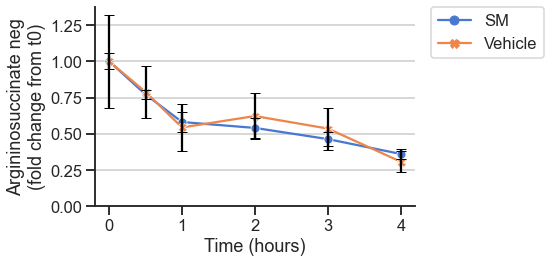

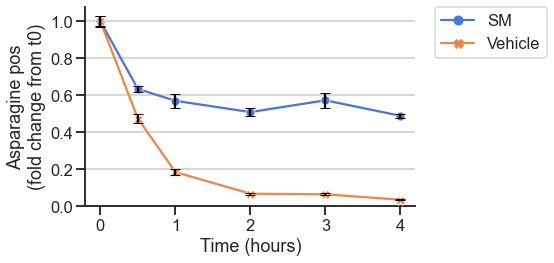

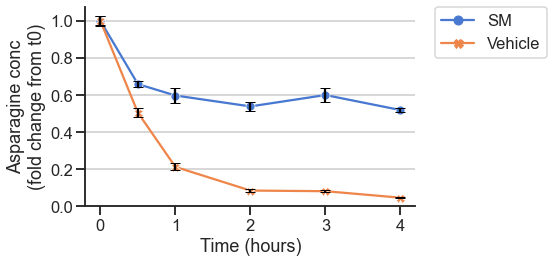

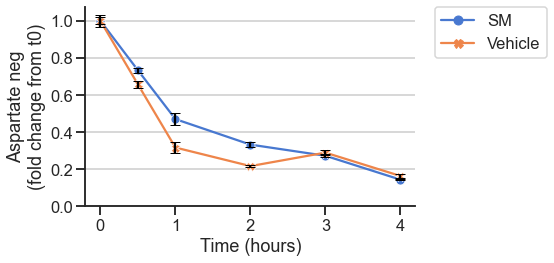

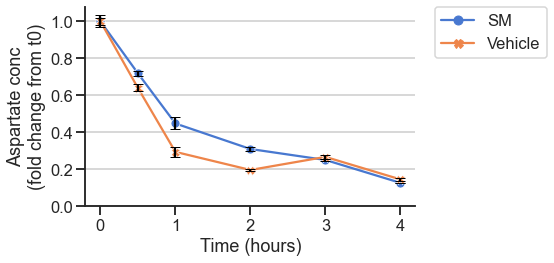

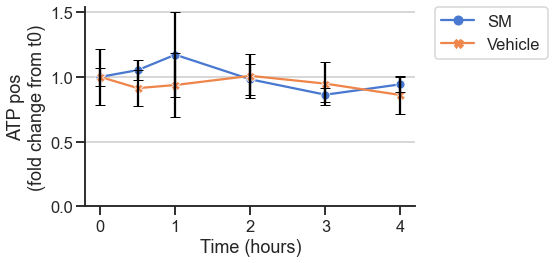

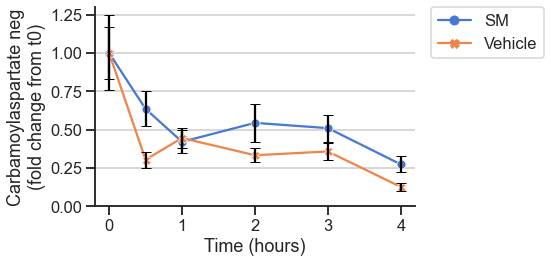

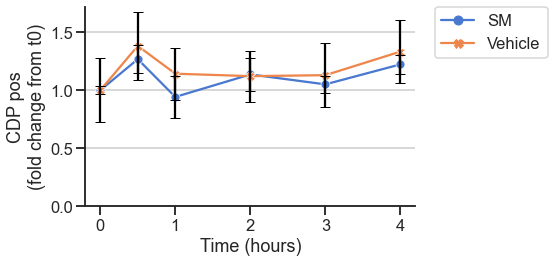

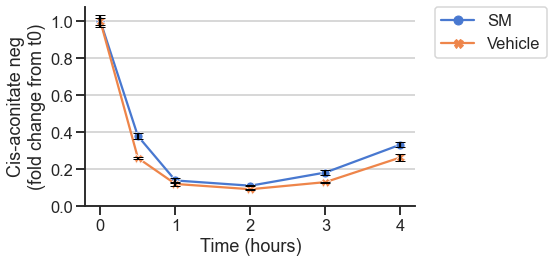

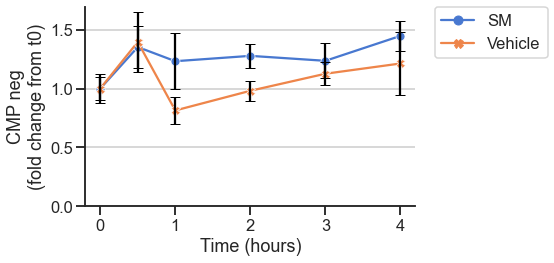

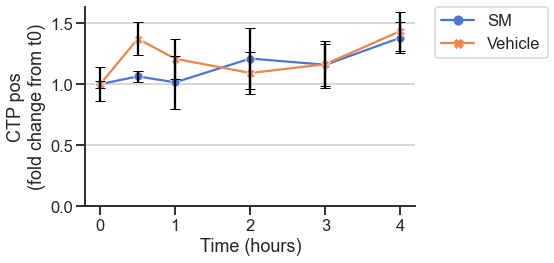

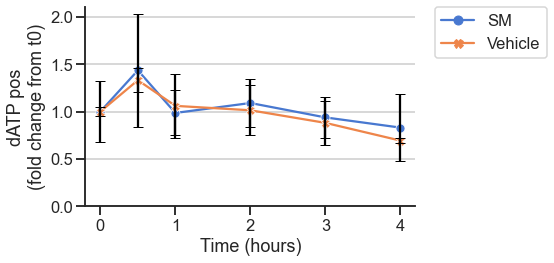

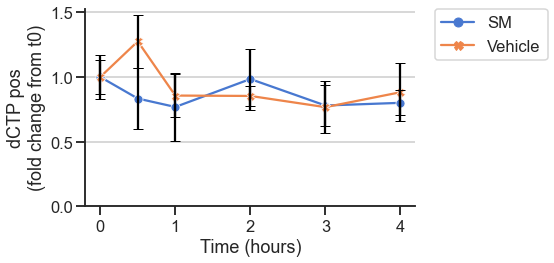

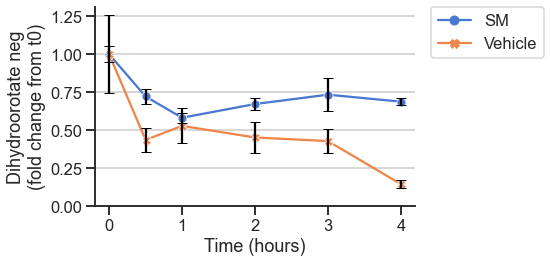

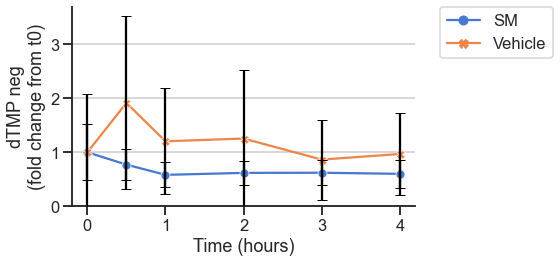

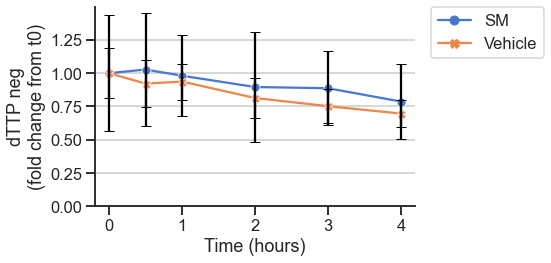

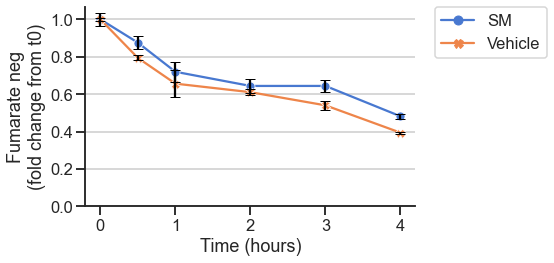

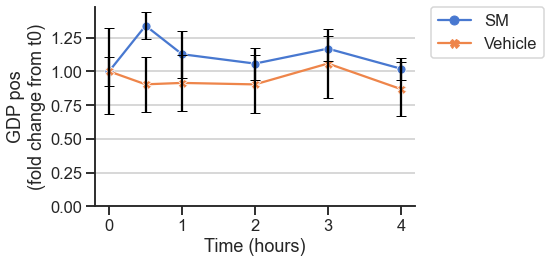

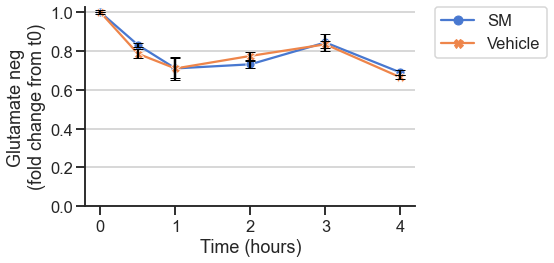

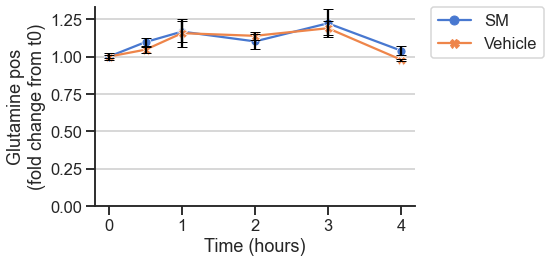

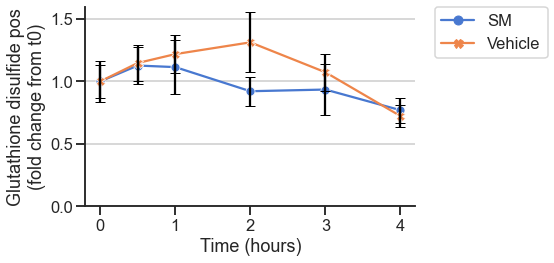

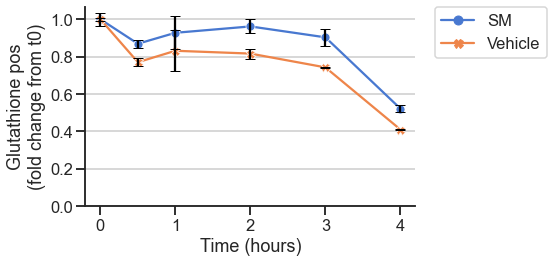

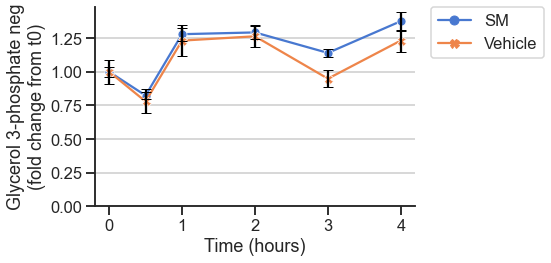

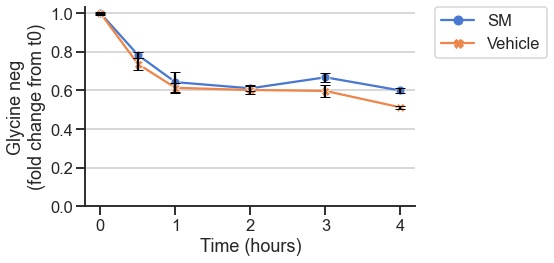

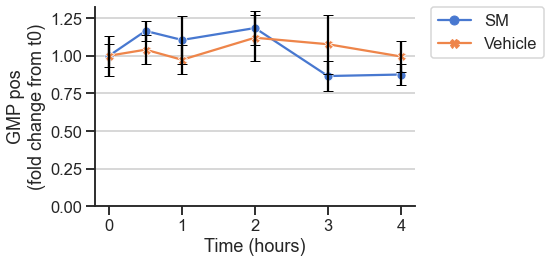

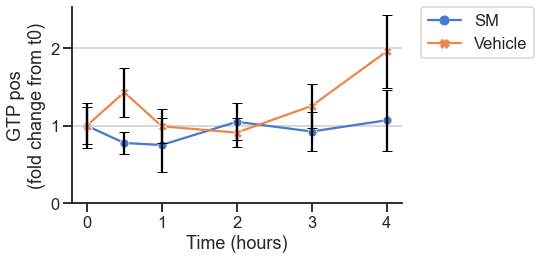

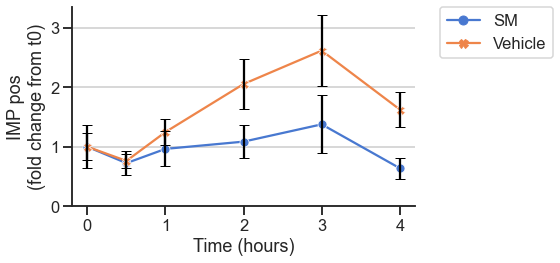

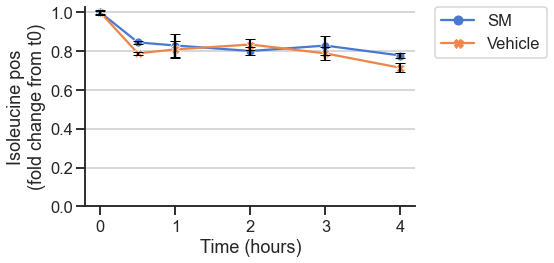

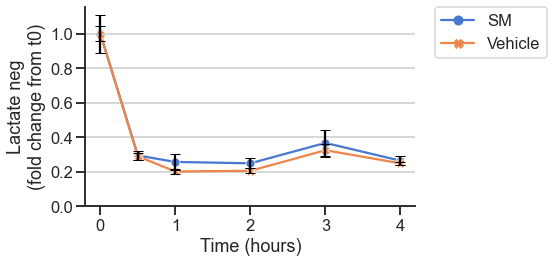

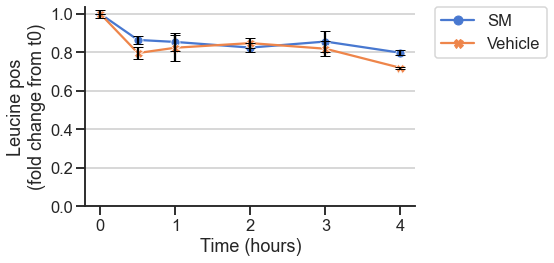

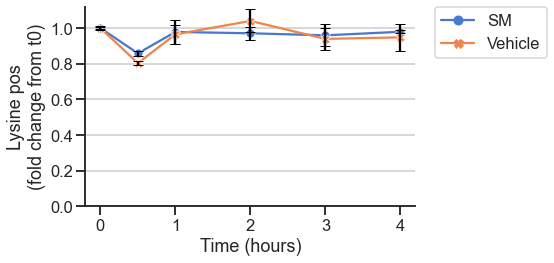

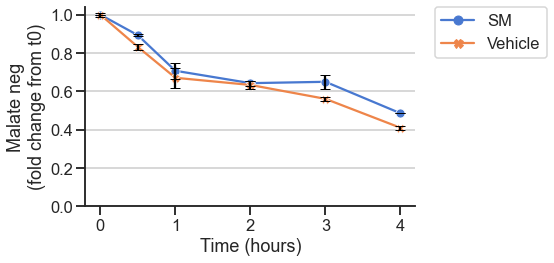

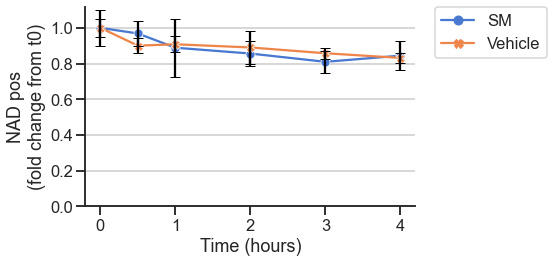

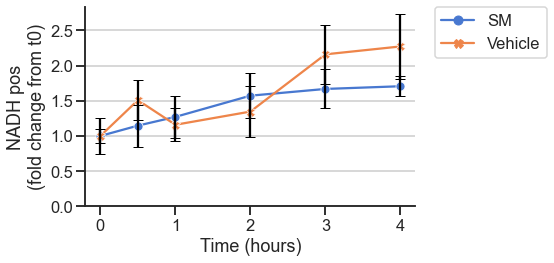

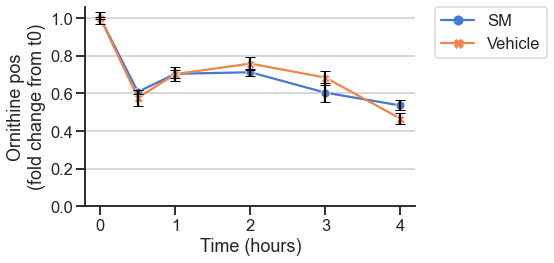

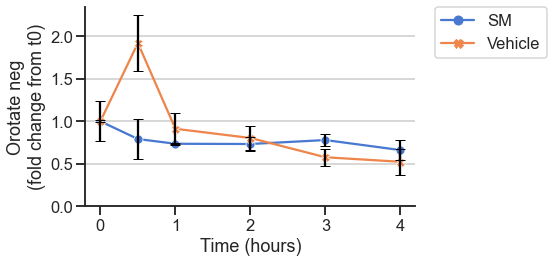

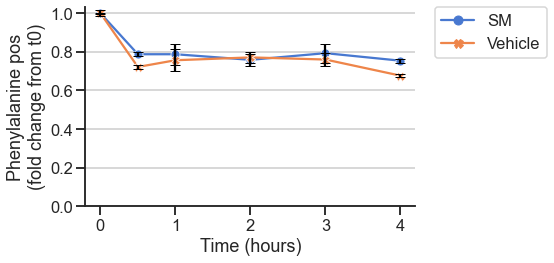

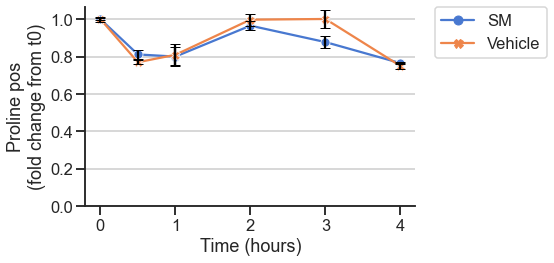

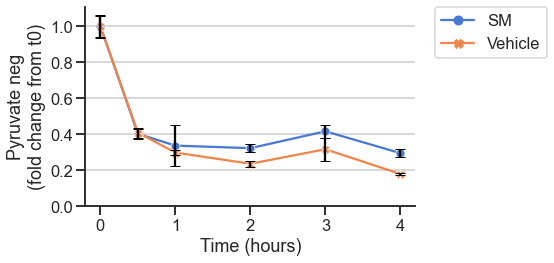

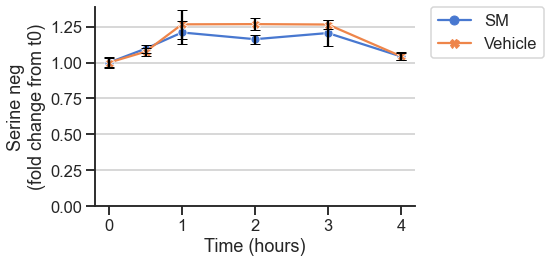

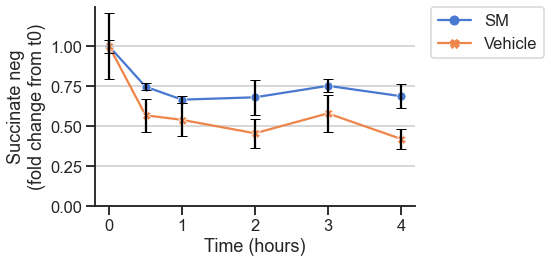

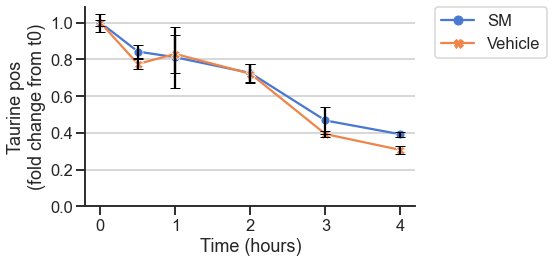

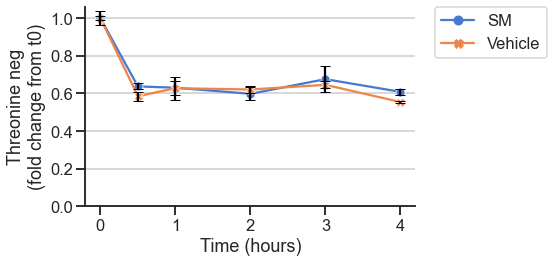

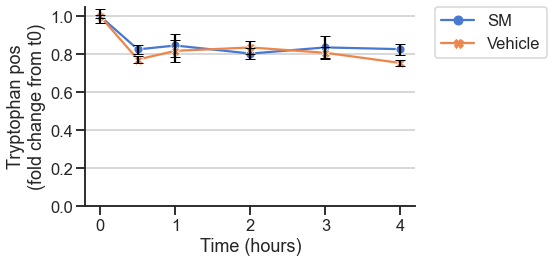

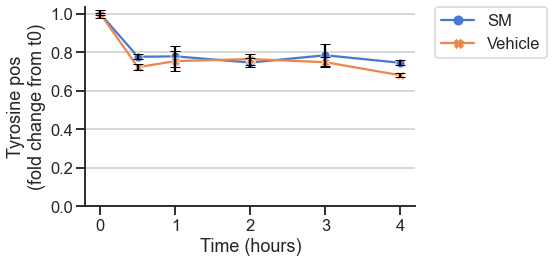

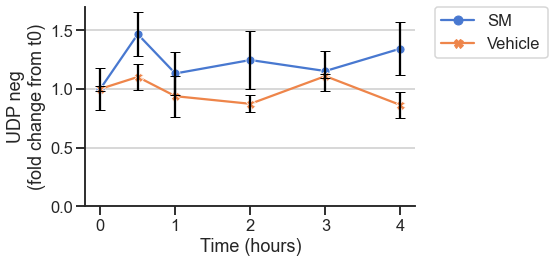

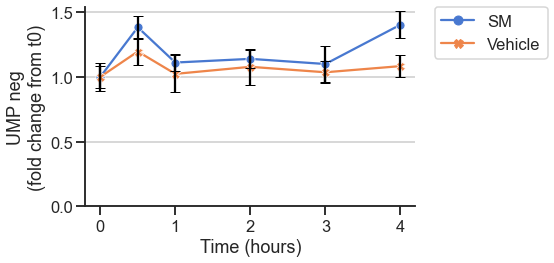

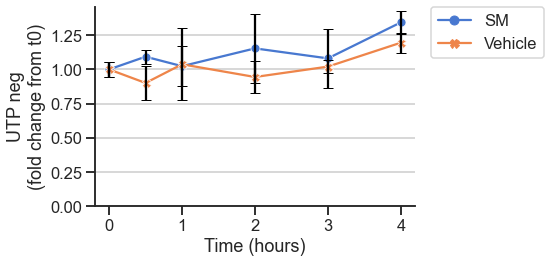

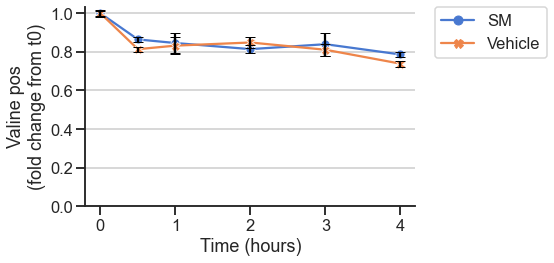

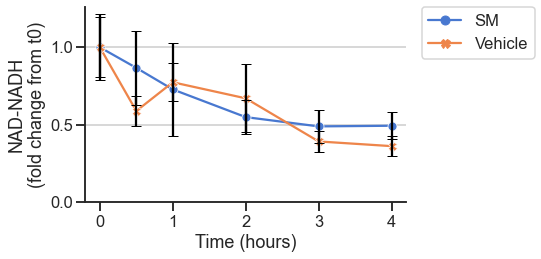

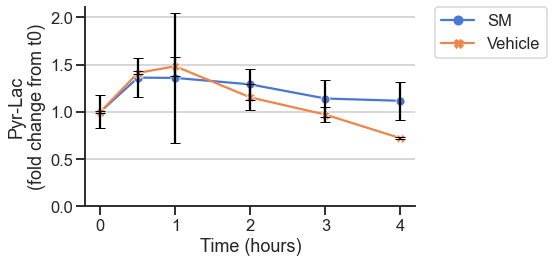

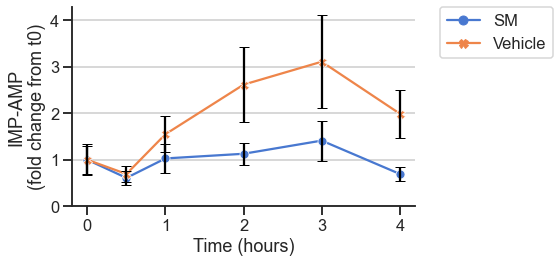

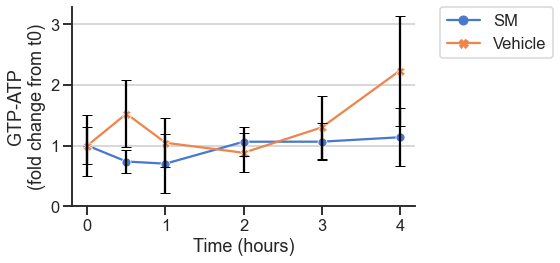

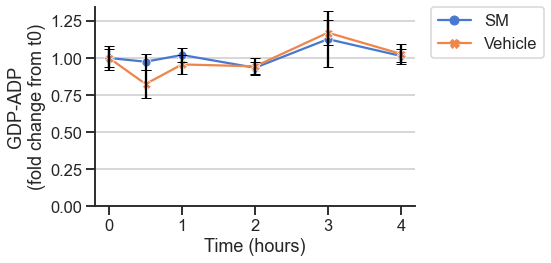

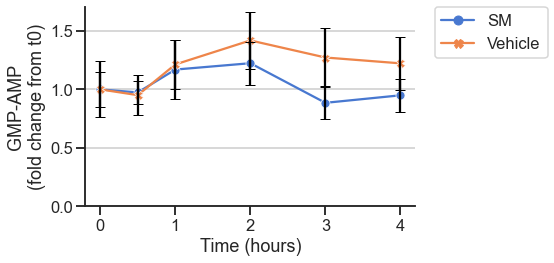

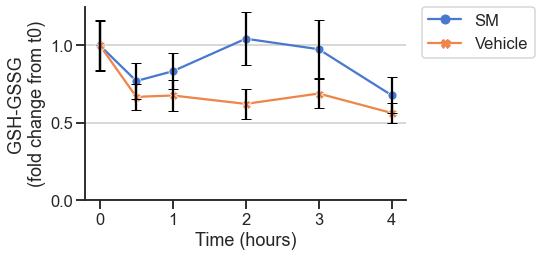

In [10]:
# Plot all ratios:
for rep in set(df_mean_norm['Repeat'].values):
    for colnam in df_mean_norm.columns.values:
        if colnam in col_exclude:
            continue

        #### Plot ####
        fig, ax1 = plt.subplots(1, 1, figsize=(9, 4))

        mask = df_mean_norm['Repeat'] == rep
        g1 = sns.lineplot(ax=ax1, data=df_mean_norm[mask], x='Time', y=colnam, hue='Rescue', style='Rescue', markers=True, dashes=False, zorder=10)
        g1.errorbar(y=df_mean_norm[mask][colnam].values, x=df_mean_norm[mask]['Time'].values, yerr=df_stdev_norm[mask][colnam].values, fmt='none', color='black', capsize=5, zorder=20)
        #g1.legend_.remove()
        g1.legend(bbox_to_anchor=(1.4, 1), borderaxespad=0)
        g1.set_ylim(0, g1.get_ylim()[1])
        g1.set_xlabel('Time (hours)')
        g1.set_ylabel('{}\n(fold change from t0)'.format(colnam))

        g1.grid(True, axis='y')
        sns.despine()
        fig.tight_layout()
        if (df_mean_norm[mask][colnam].values.max() / df_mean_norm[mask][colnam].values.min()) > 2:
            fig.savefig('plots/ratio_change/rep-{}_over2Xdiff_{}.pdf'.format(rep, colnam.replace(' ', '-')), bbox_inches='tight')
        else:
            fig.savefig('plots/ratio_change/rep-{}_{}.pdf'.format(rep, colnam.replace(' ', '-')), bbox_inches='tight')


<ipython-input-11-f693b2af3023>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(1, 1, figsize=(9, 4))


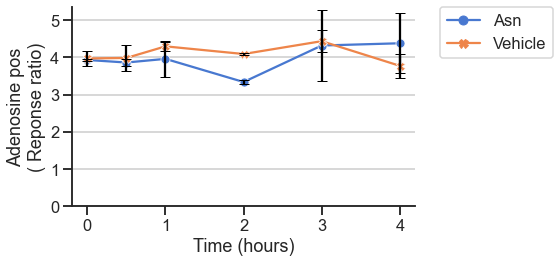

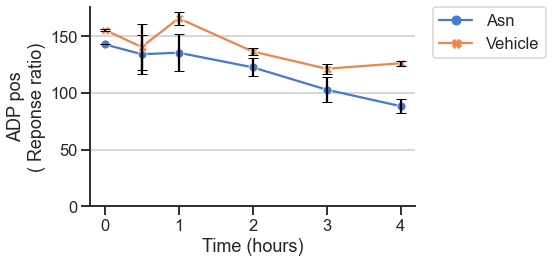

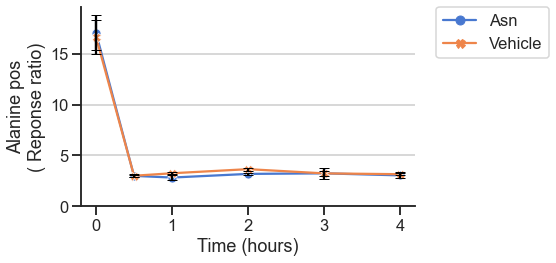

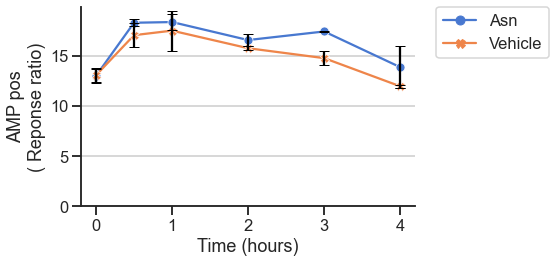

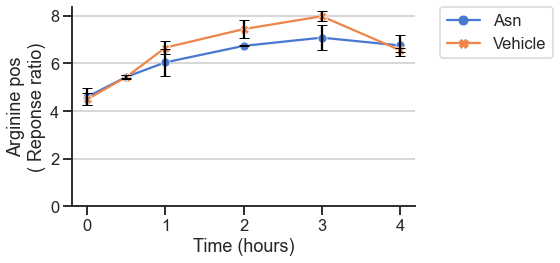

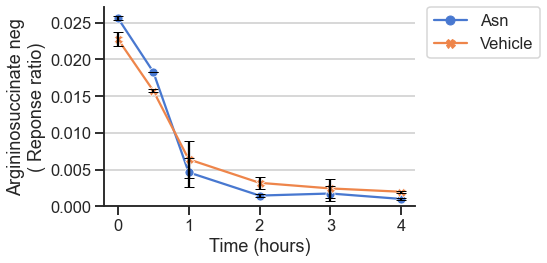

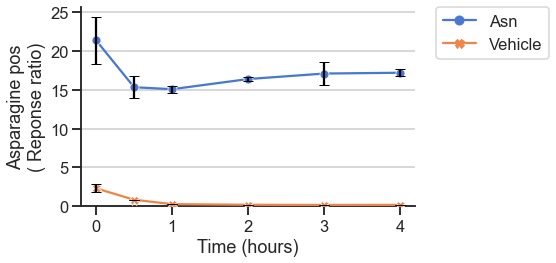

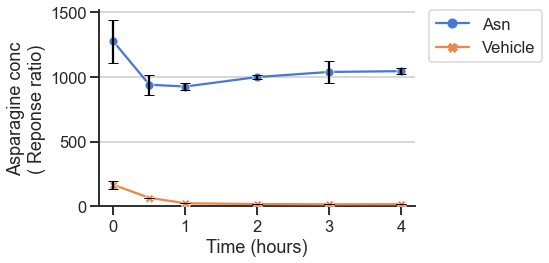

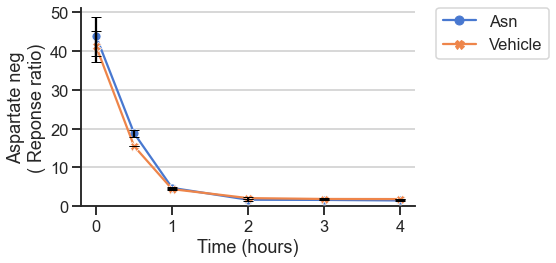

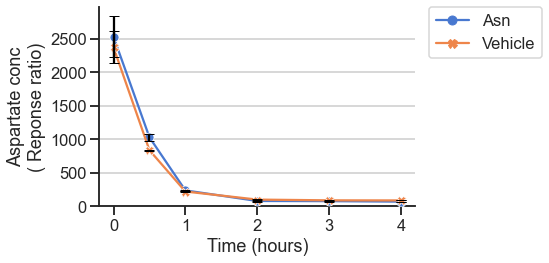

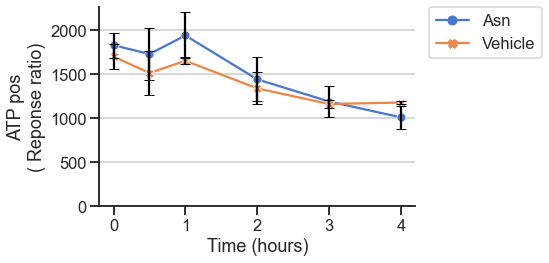

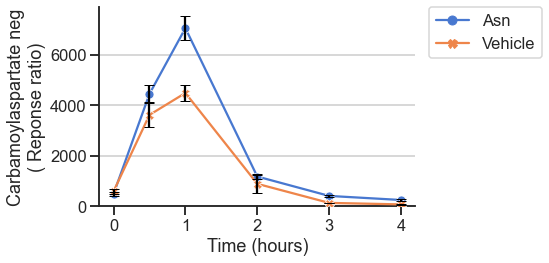

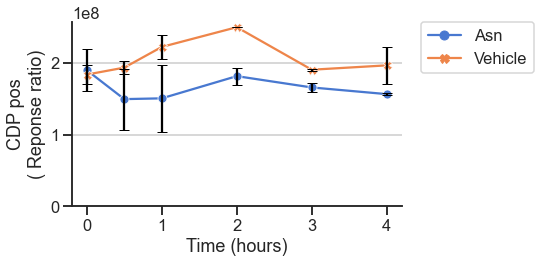

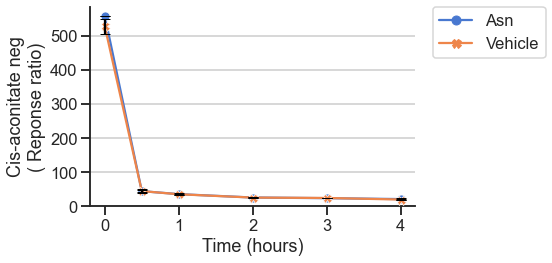

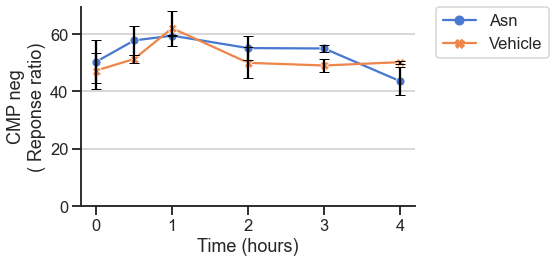

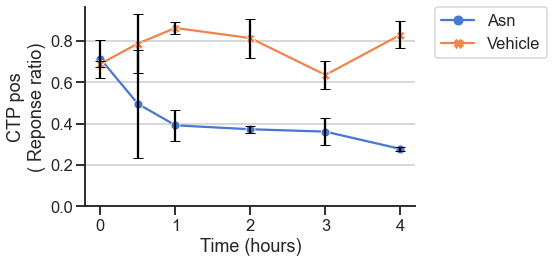

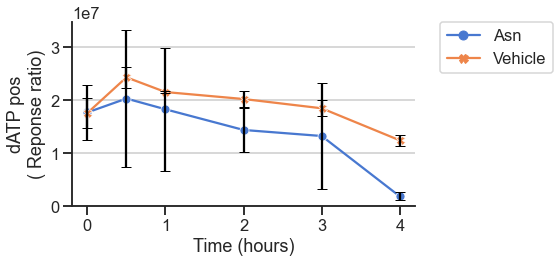

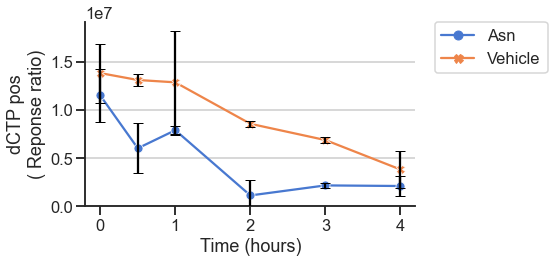

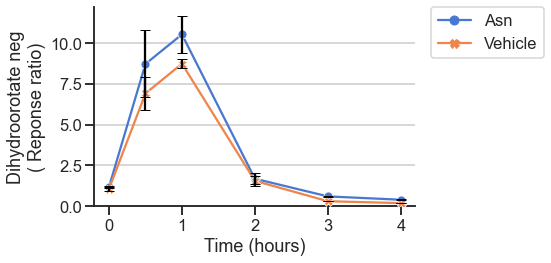

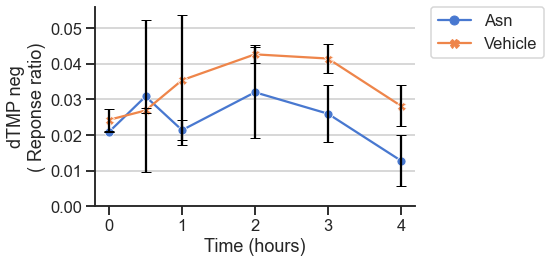

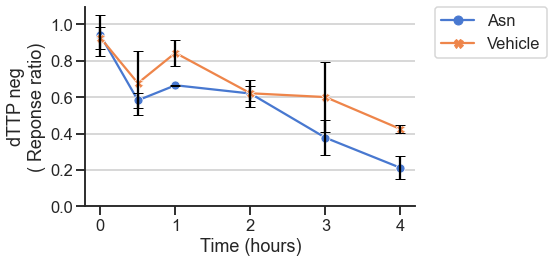

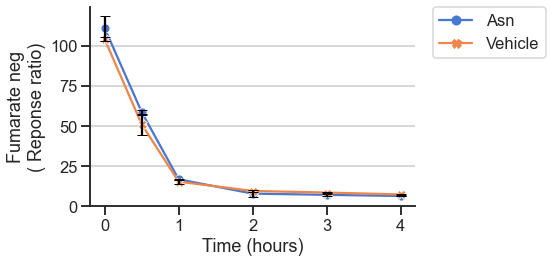

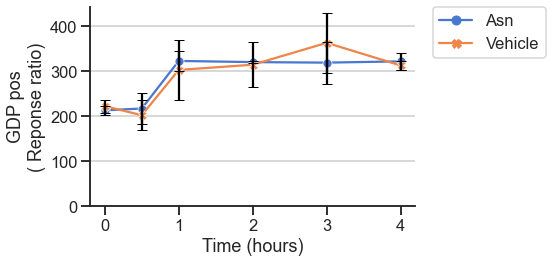

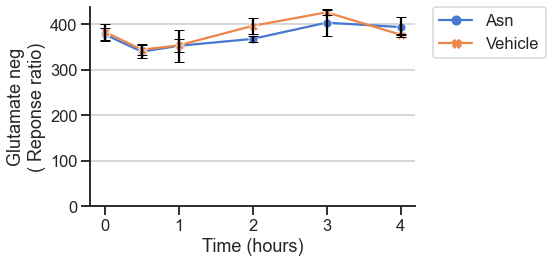

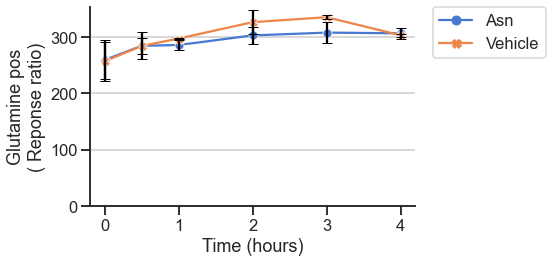

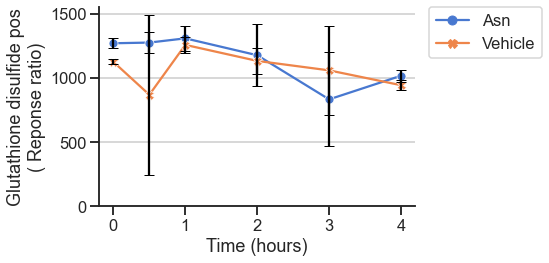

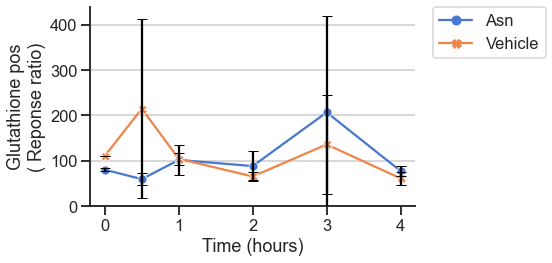

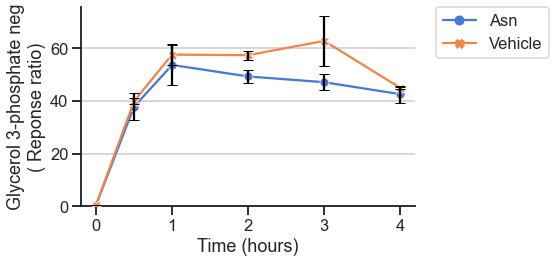

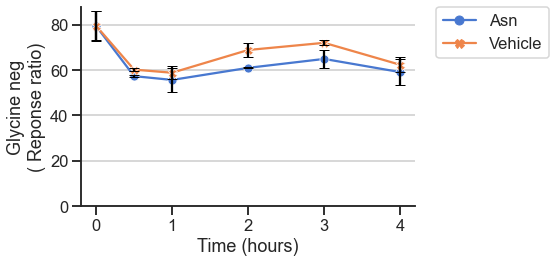

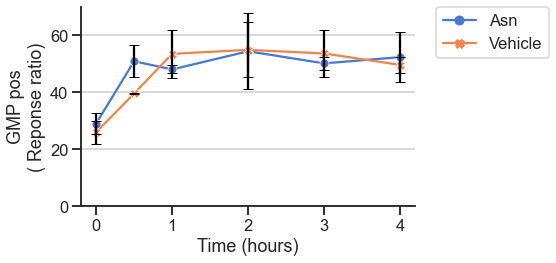

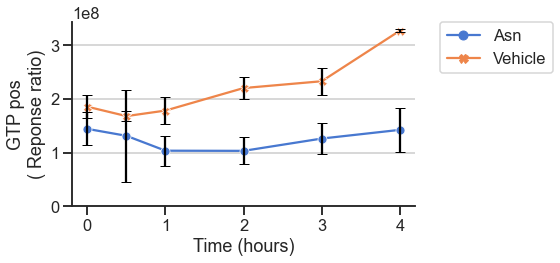

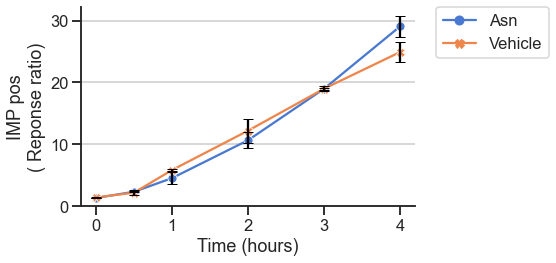

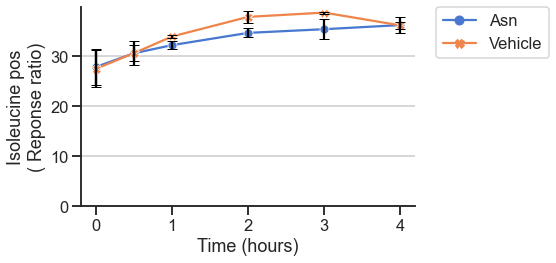

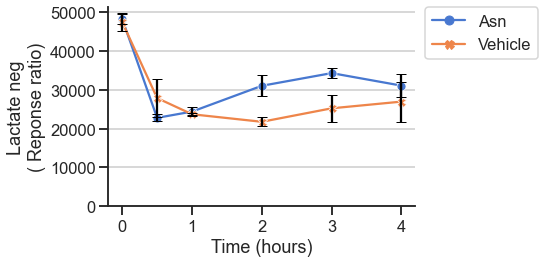

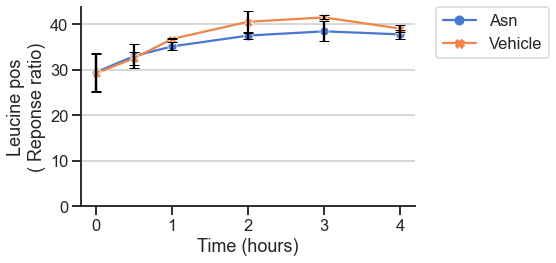

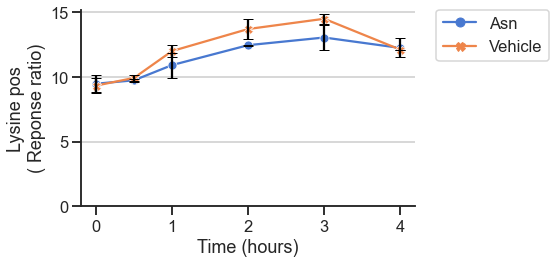

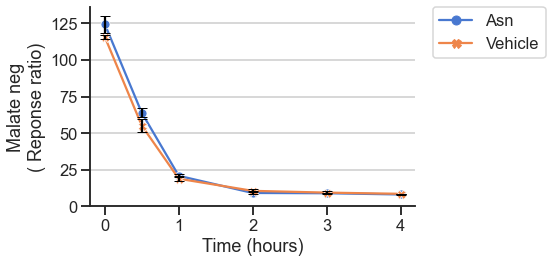

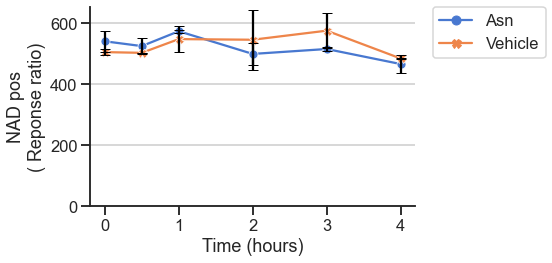

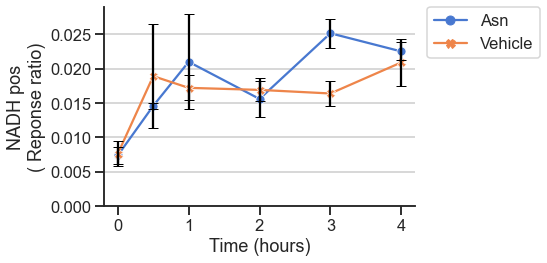

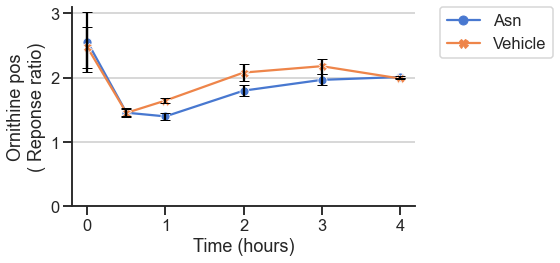

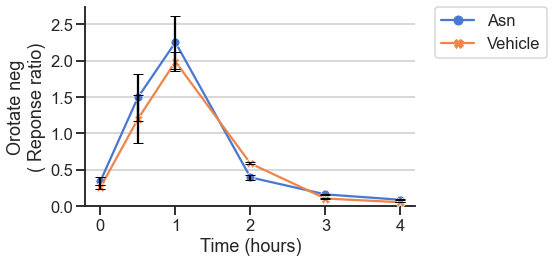

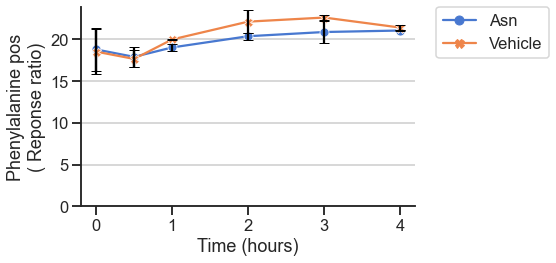

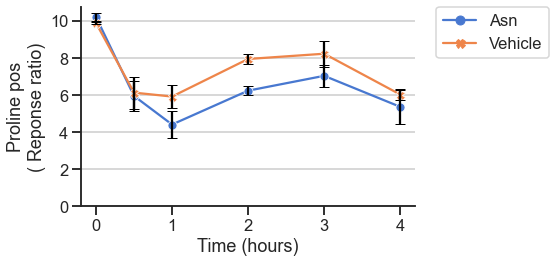

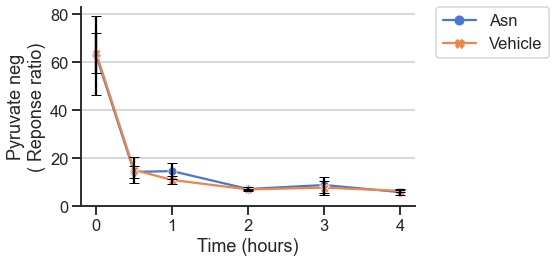

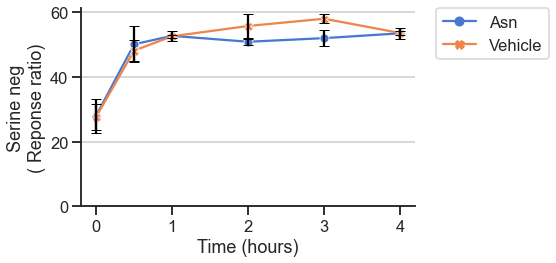

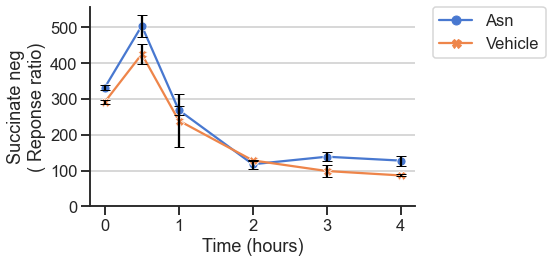

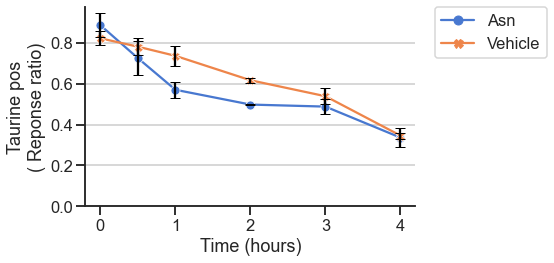

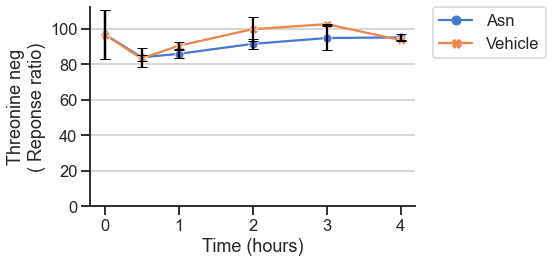

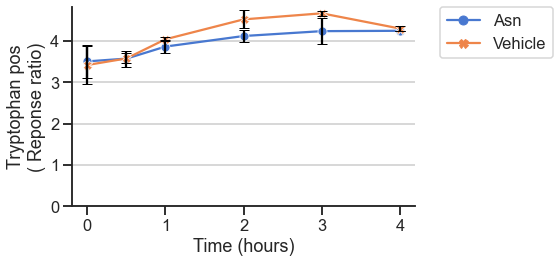

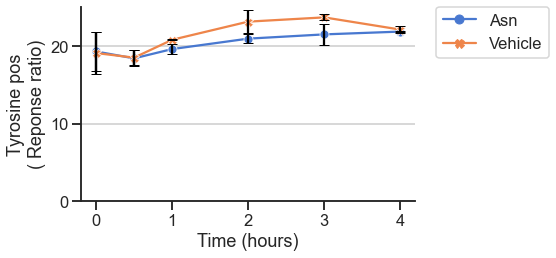

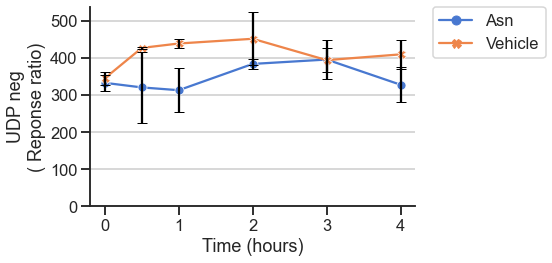

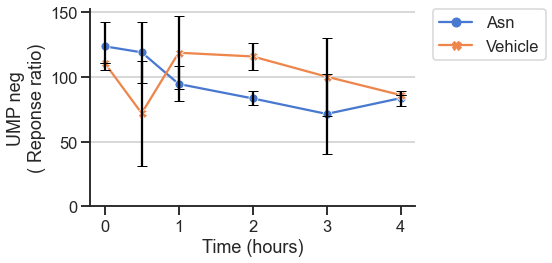

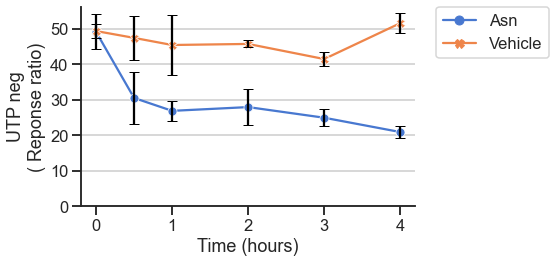

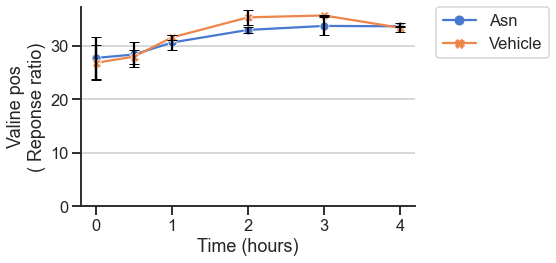

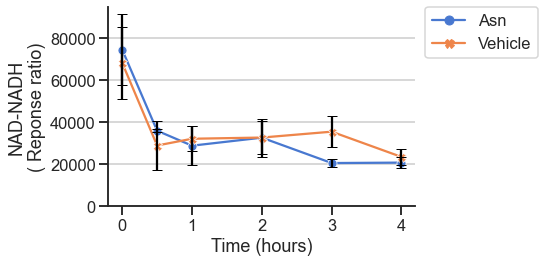

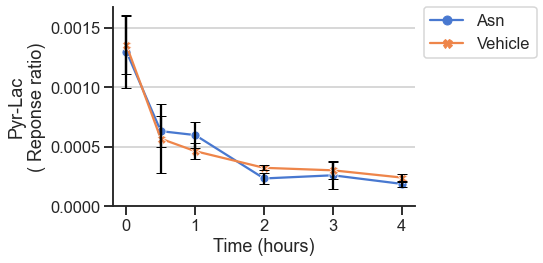

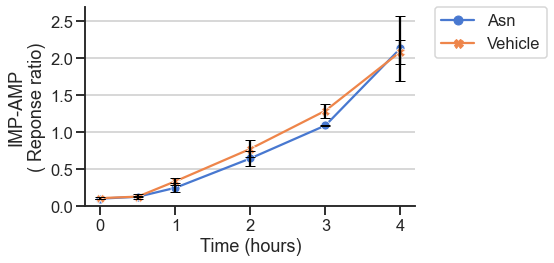

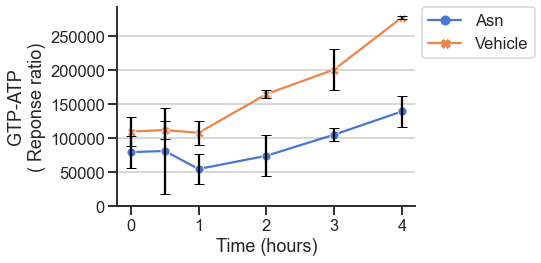

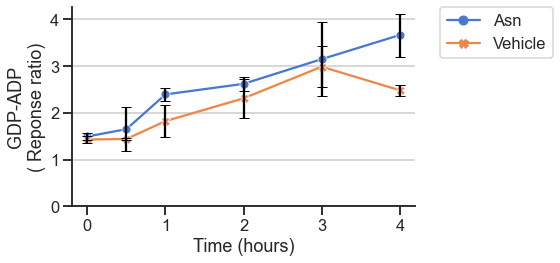

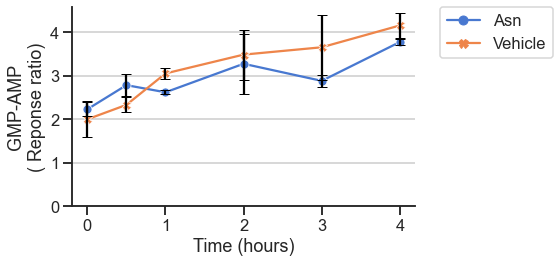

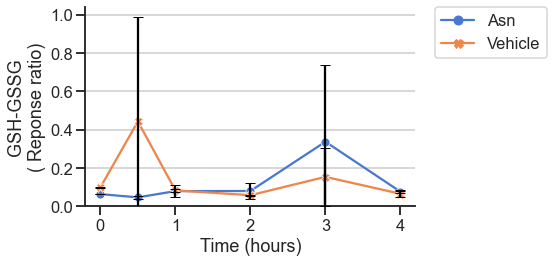

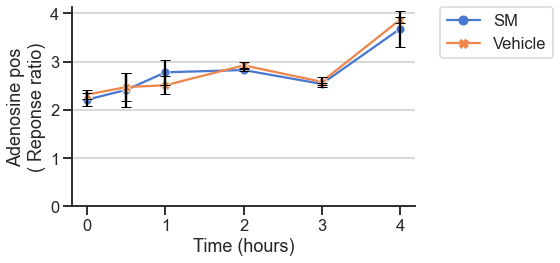

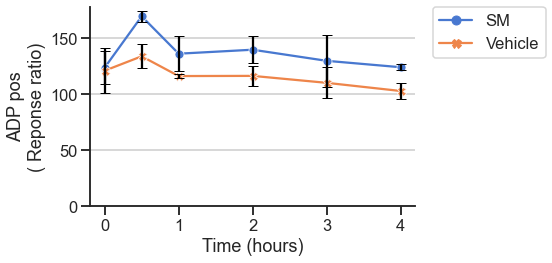

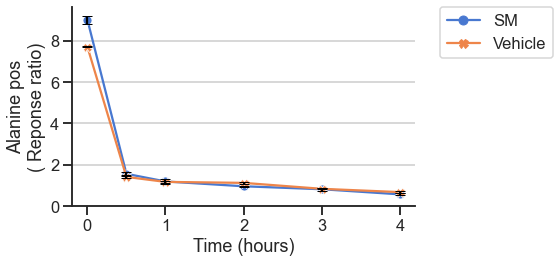

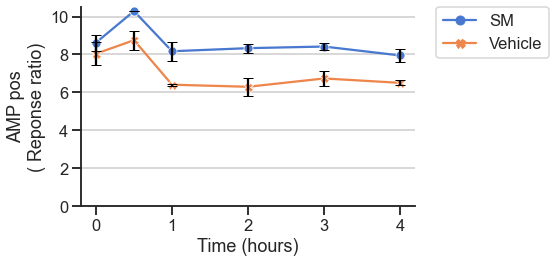

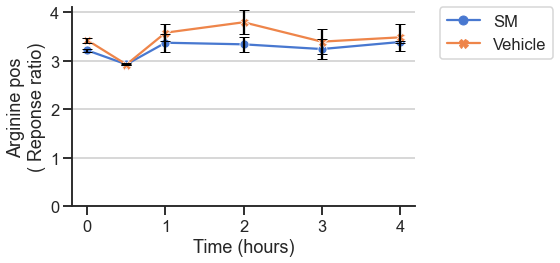

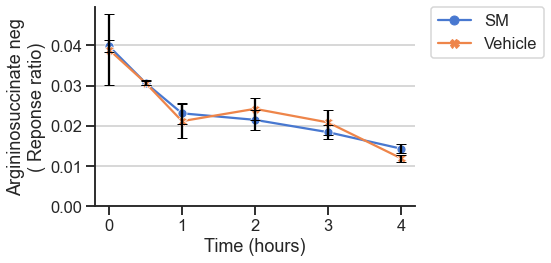

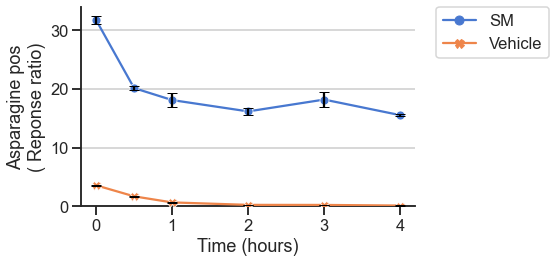

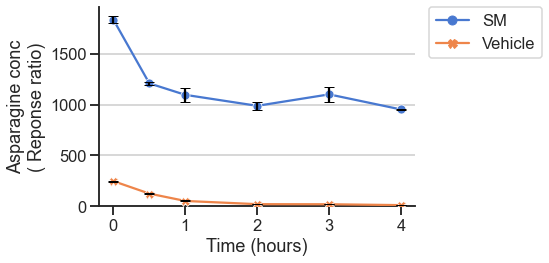

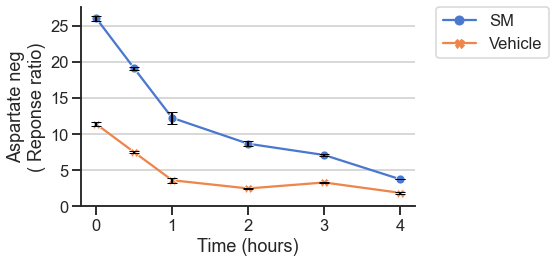

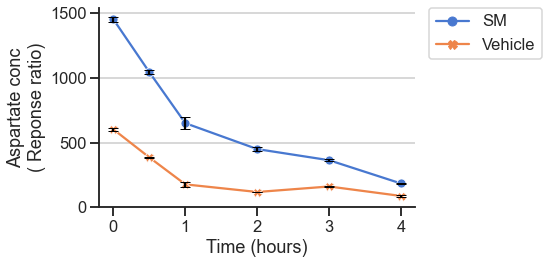

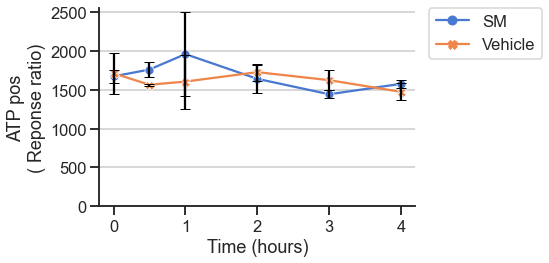

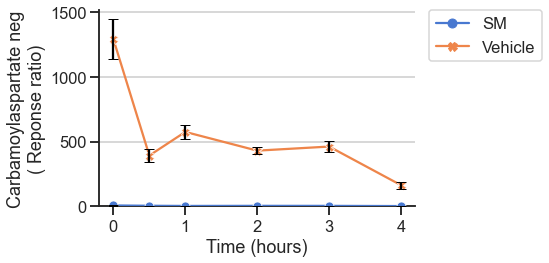

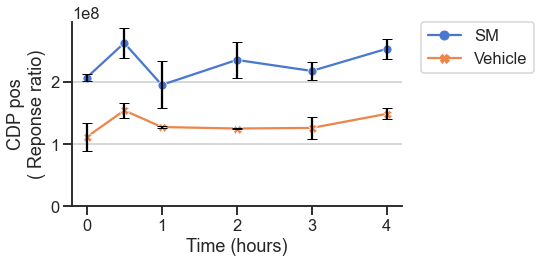

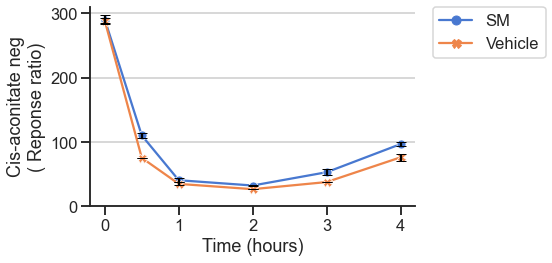

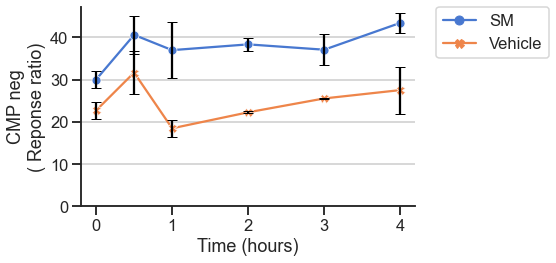

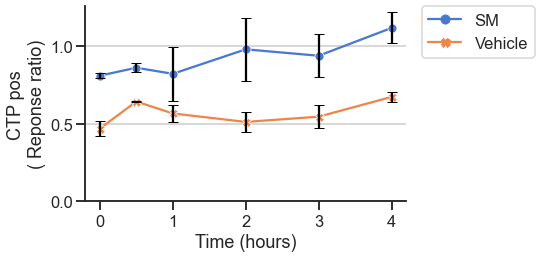

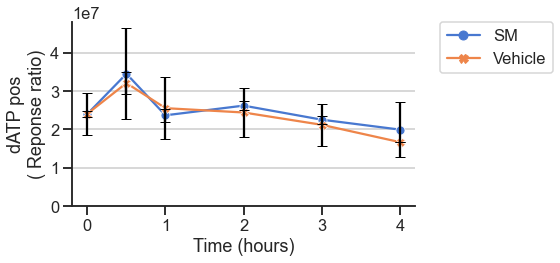

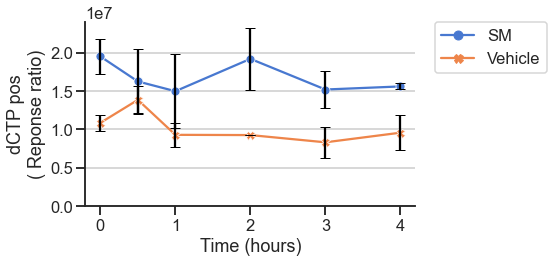

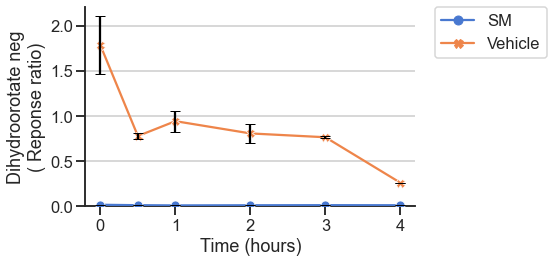

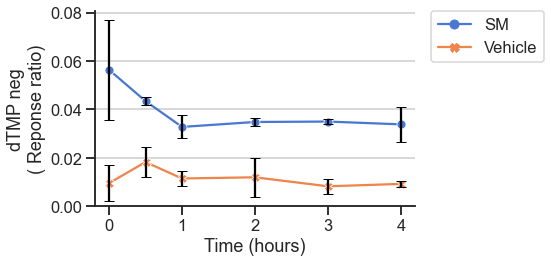

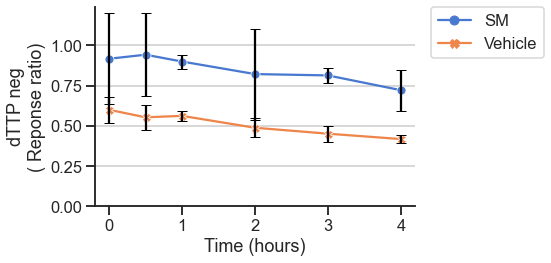

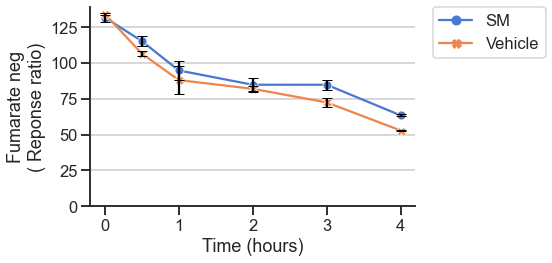

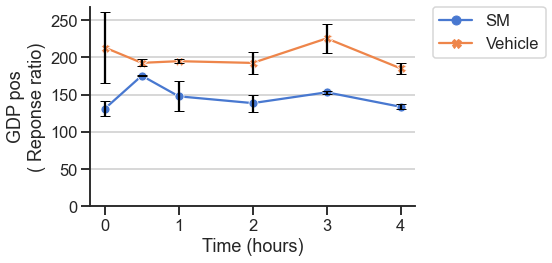

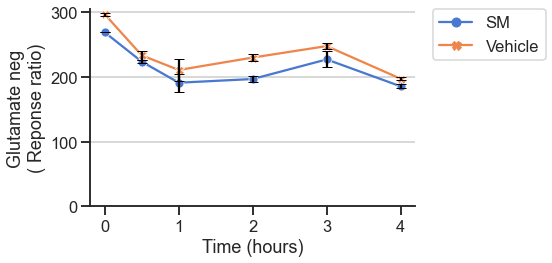

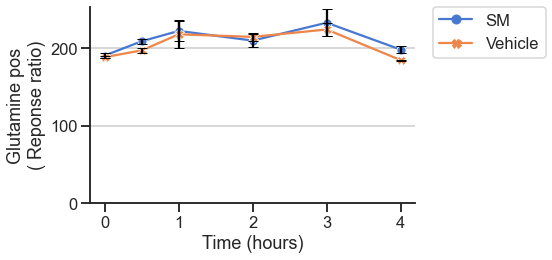

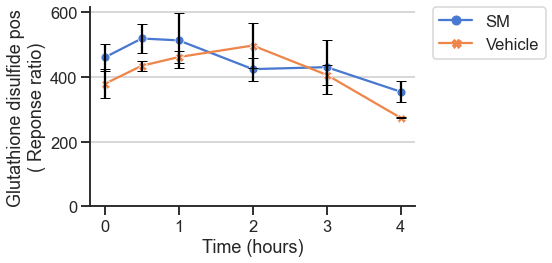

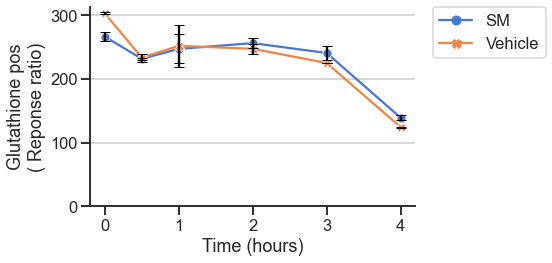

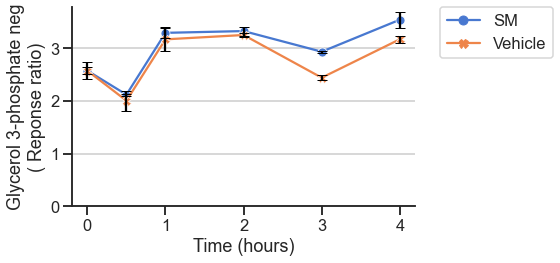

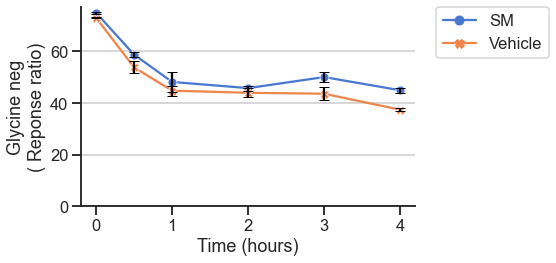

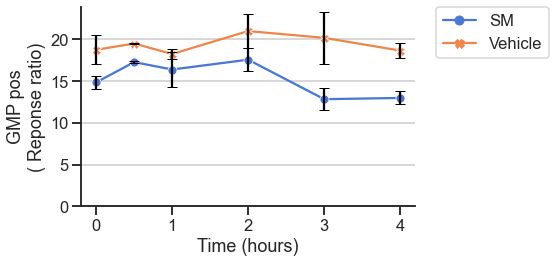

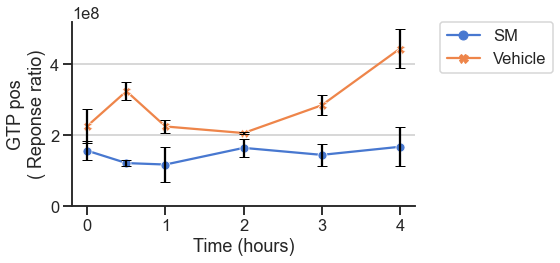

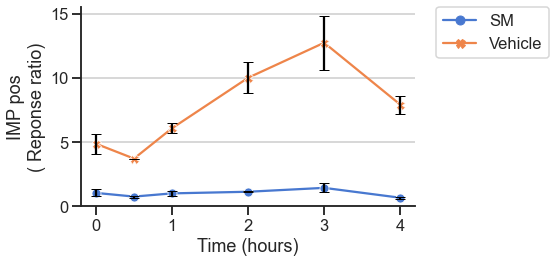

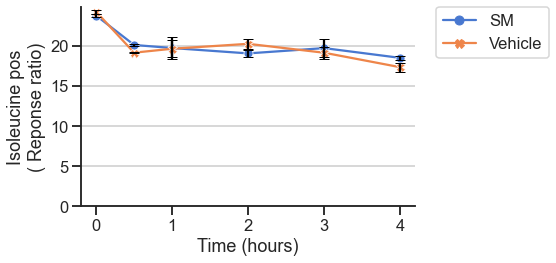

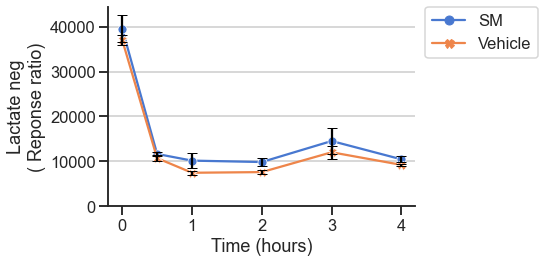

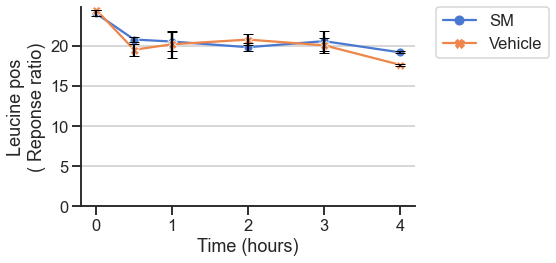

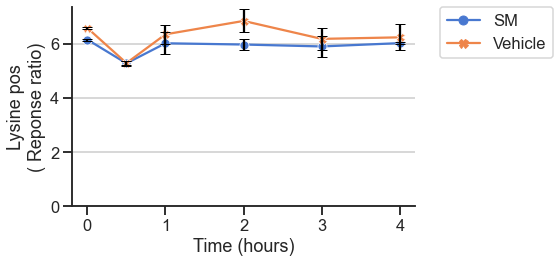

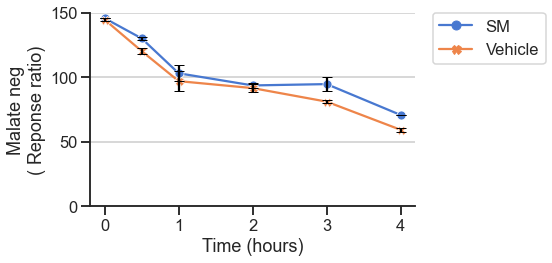

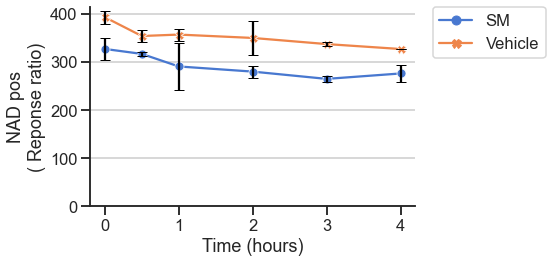

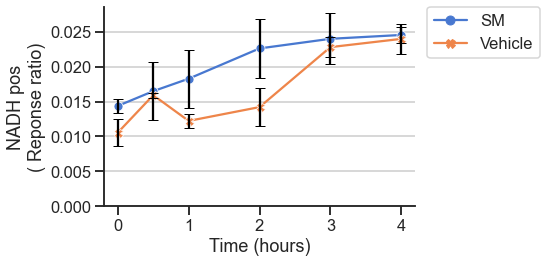

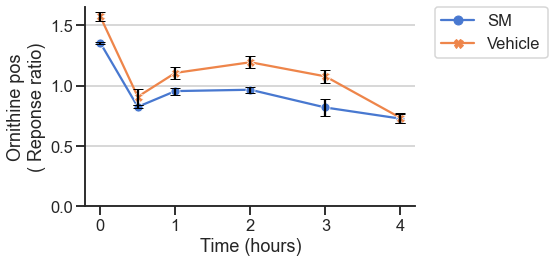

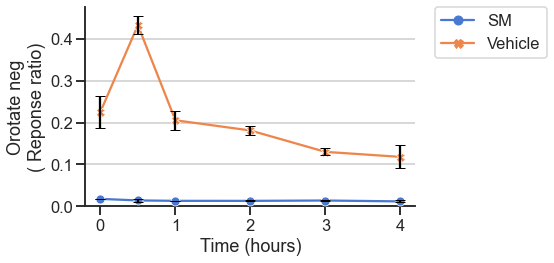

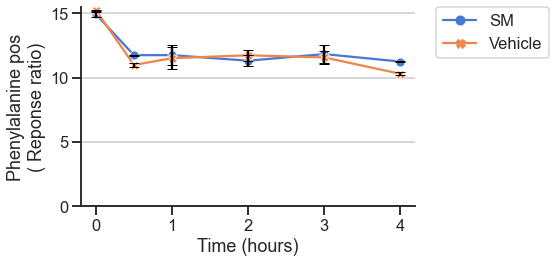

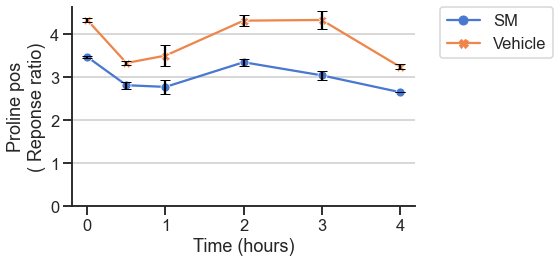

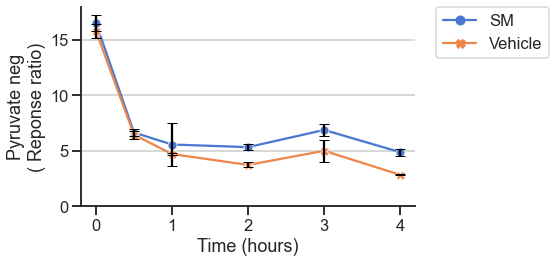

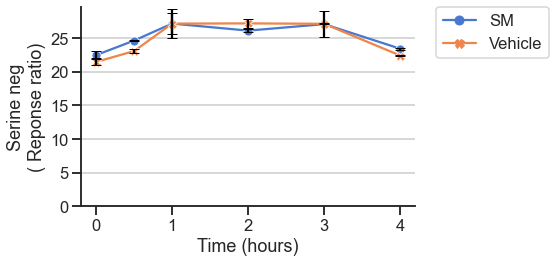

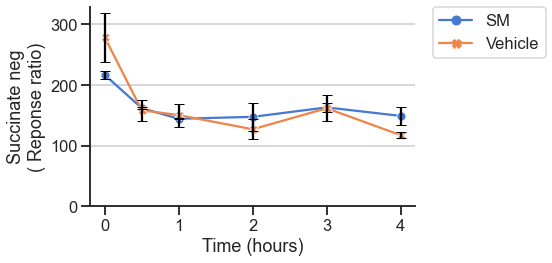

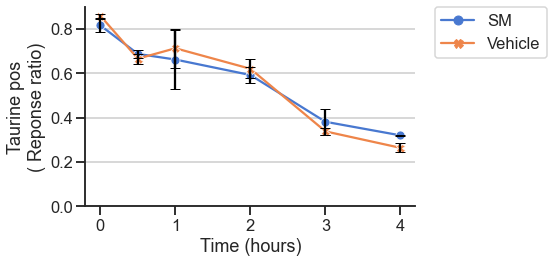

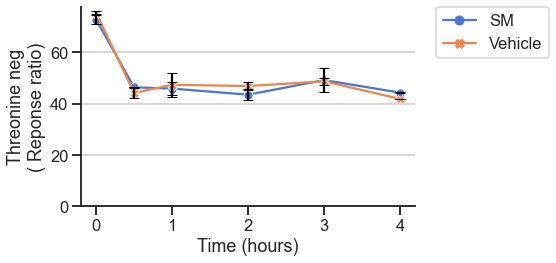

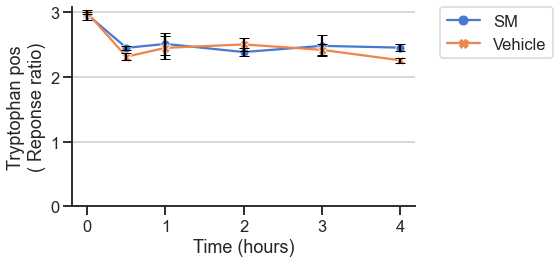

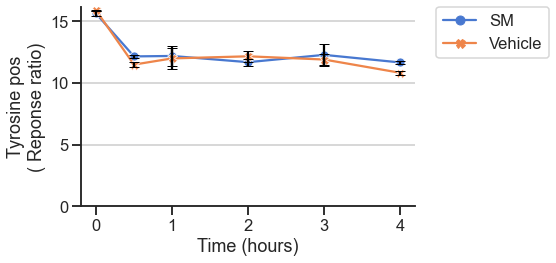

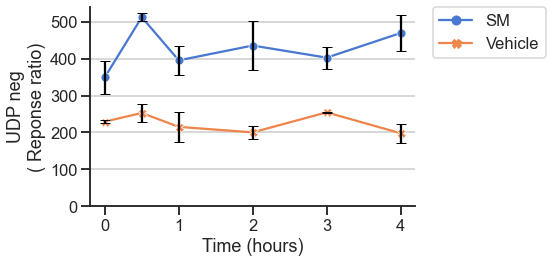

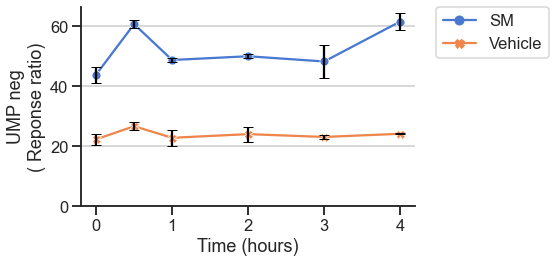

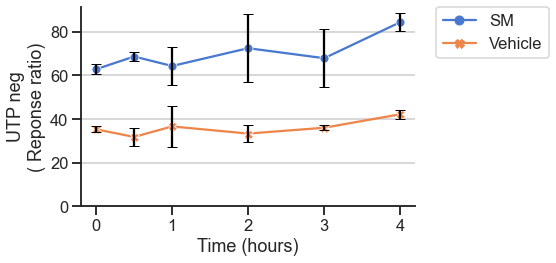

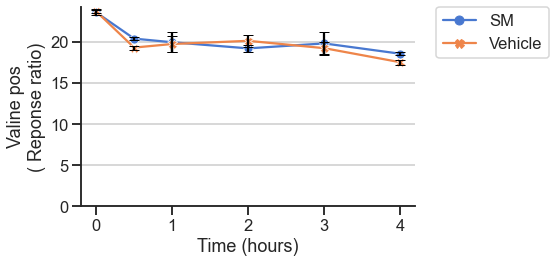

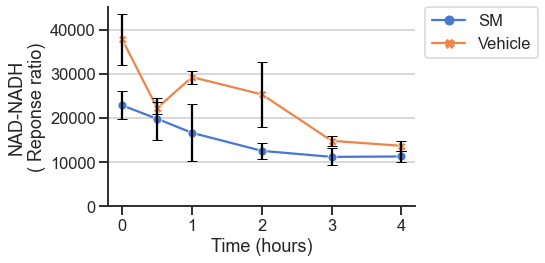

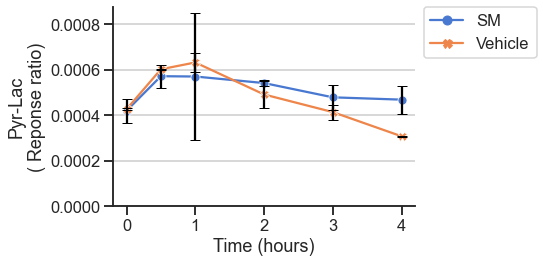

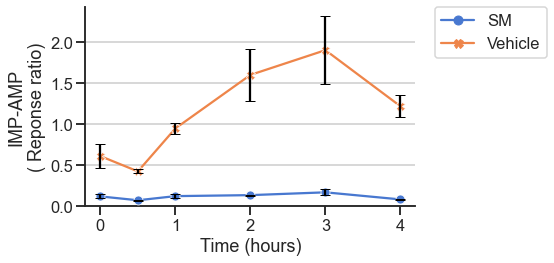

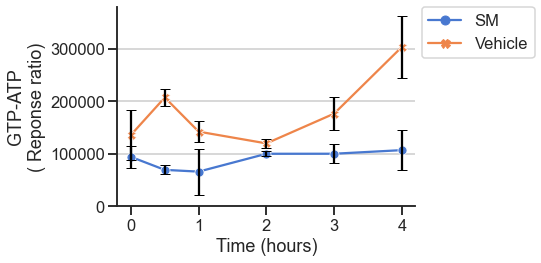

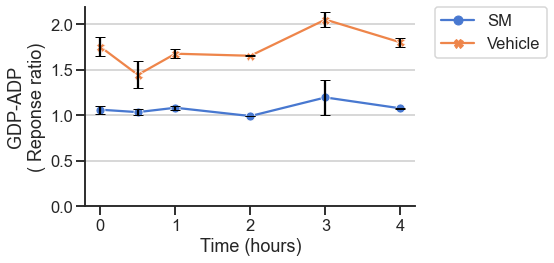

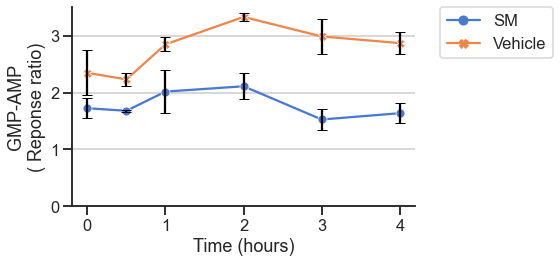

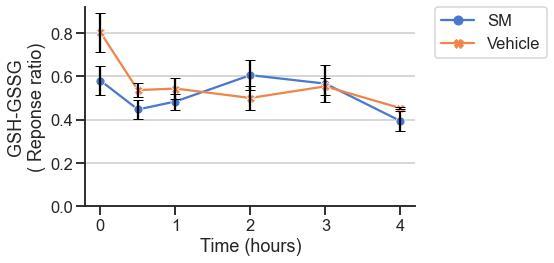

In [11]:
# Plot all ratios:
for rep in set(df_mean['Repeat'].values):
    for colnam in df_mean.columns.values:
        if colnam in col_exclude:
            continue

        #### Plot ####
        fig, ax1 = plt.subplots(1, 1, figsize=(9, 4))

        mask = df_mean['Repeat'] == rep
        g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Time', y=colnam, hue='Rescue', style='Rescue', markers=True, dashes=False, zorder=10)
        g1.errorbar(y=df_mean[mask][colnam].values, x=df_mean[mask]['Time'].values, yerr=df_stdev[mask][colnam].values, fmt='none', color='black', capsize=5, zorder=20)
        #g1.legend_.remove()
        g1.legend(bbox_to_anchor=(1.4, 1), borderaxespad=0)
        g1.set_ylim(0, g1.get_ylim()[1])
        g1.set_xlabel('Time (hours)')
        g1.set_ylabel('{}\n( Reponse ratio)'.format(colnam))

        g1.grid(True, axis='y')
        sns.despine()
        fig.tight_layout()
        if (df_mean_norm[mask][colnam].values.max() / df_mean_norm[mask][colnam].values.min()) > 2:
            fig.savefig('plots/response_change/rep-{}_over2Xdiff_{}.pdf'.format(rep, colnam.replace(' ', '-')), bbox_inches='tight')
        else:
            fig.savefig('plots/response_change/rep-{}_{}.pdf'.format(rep, colnam.replace(' ', '-')), bbox_inches='tight')


In [12]:
# Get normalized data:
df_v2 = df[df['Repeat'] == 'v2'].copy().reset_index(drop=True)
col_exclude2 = ['Sample ID', 'Sample_name', 'Time', 'Aspartate_media', 'Sample ID', 'ISTD Amt', 'Replicate', 'dilution', 'Rescue', 'Antimycin (uM)', 'Repeat']
mcol = ~df_v2.columns.isin(col_exclude2)
df_norm = copy.deepcopy(df_v2)
df_norm.loc[:, mcol] = df_v2.loc[:, mcol].values / df_mean.loc[(df_mean['Time']==0)&(df_mean['Rescue']=='Vehicle')&(df_mean['Repeat']=='v2'), ~df_mean.columns.isin(col_exclude2)].values

In [13]:
pyrimidines = ['Carbamoylaspartate neg', 'Dihydroorotate neg', 'Orotate neg']
UXP = ['UMP neg', 'UDP neg', 'UTP neg']
CXP = ['CMP neg', 'CDP pos', 'CTP pos']
purines = ['IMP pos', 'IMP-AMP']
GXP = ['GMP pos', 'GDP pos', 'GTP pos']
AXP = ['AMP pos', 'ADP pos', 'ATP pos']
purine_ratios = ['IMP-AMP', 'GMP-AMP', 'GDP-ADP', 'GTP-ATP']
dNTPs = ['dATP pos', 'dCTP pos', 'dTTP neg']
tca = ['Cis-aconitate neg', 'Succinate neg', 'Fumarate neg', 'Malate neg']
redox = ['NADH pos', 'Glycerol 3-phosphate neg']
aa = ['Aspartate neg', 'Asparagine pos', 'Proline pos']

plot_list = {'Pyrimidines': pyrimidines,
             'UXP': UXP,
             'CXP': CXP,
             'Purines': purines,
             'GXP': GXP,
             'AXP': AXP,
             'Purine ratios': purine_ratios,
             'dNTPs': dNTPs,
             'TCA metabolites': tca,
             'Redox': redox,
             'Amino acids': aa}

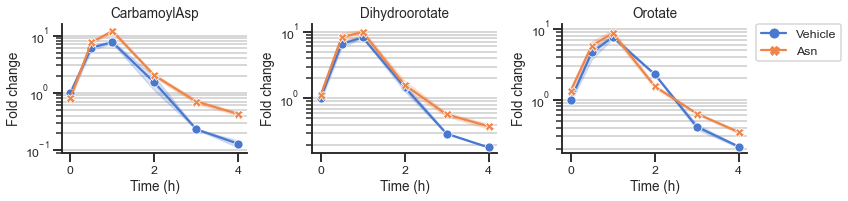

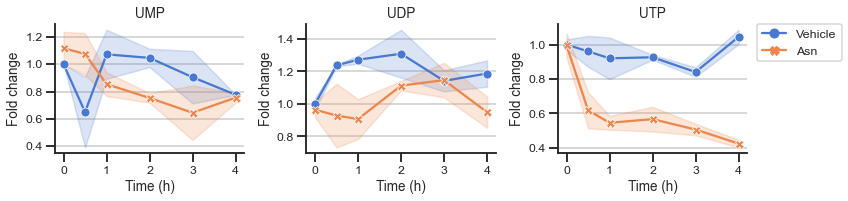

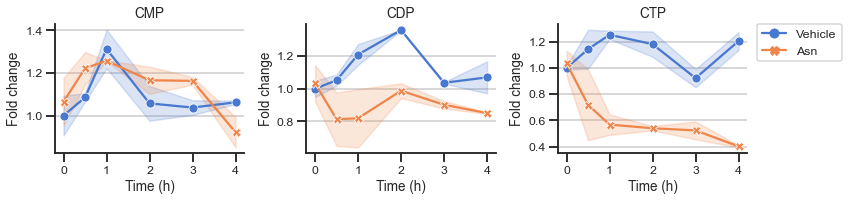

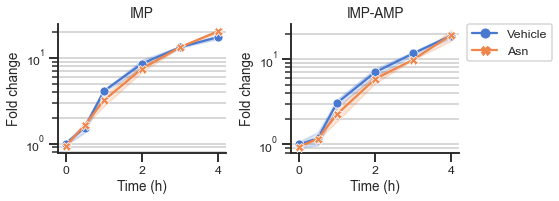

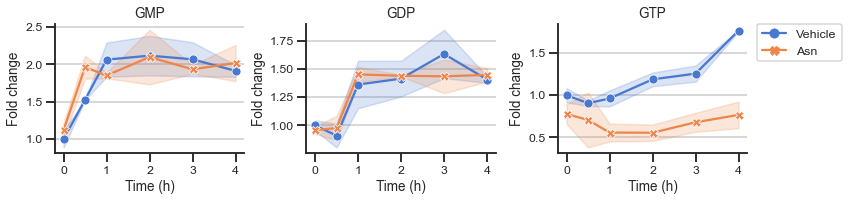

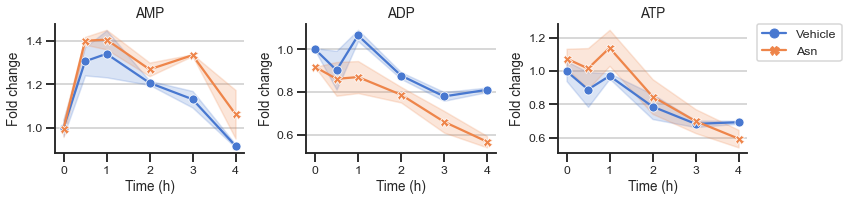

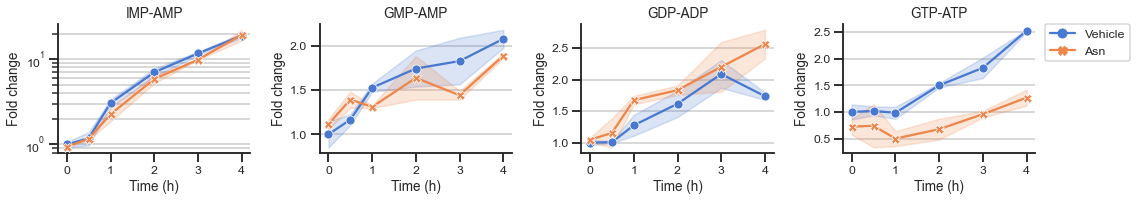

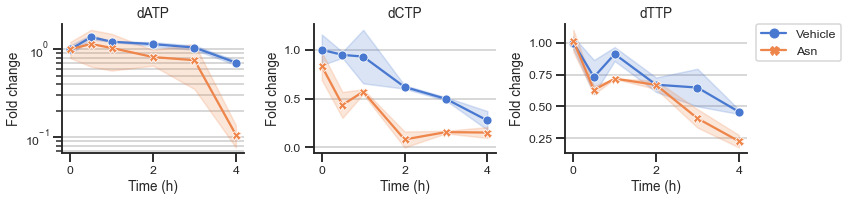

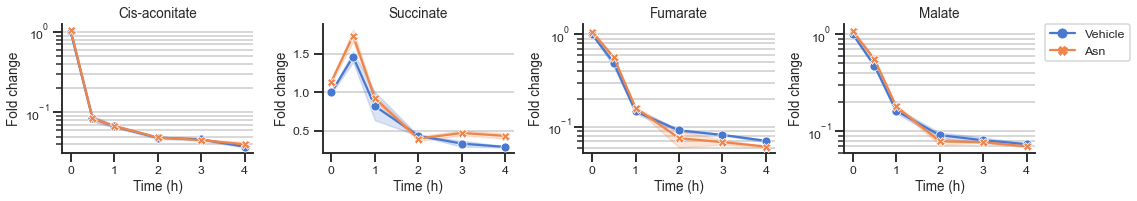

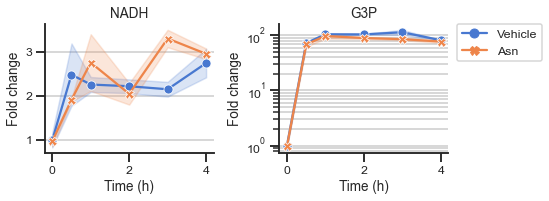

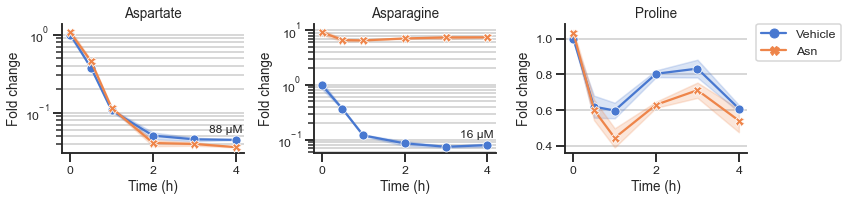

In [14]:
# Plot relevant ratios:

sns.set_context("talk", font_scale=0.75)

for plot_grp in plot_list.keys():
#for plot_grp in {'Amino acids': aa}.keys():
    metab_lst = plot_list[plot_grp]
    Nmetab = len(metab_lst)
    
    
    #### Plot ####
    fig, axes = plt.subplots(1, Nmetab, figsize=(4*Nmetab, 3))
    mi = 1
    for metab_name, ax in zip(metab_lst, axes):
        mask_t0 = df_norm['Time'] == 0
        g1 = sns.lineplot(ax=ax, data=df_norm, x='Time', y=metab_name, hue='Rescue', style='Rescue', markers=True, dashes=False, zorder=10)
        if mi < Nmetab:
            g1.legend_.remove()
            mi += 1
        else:
            g1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
        g1.set_xlabel('Time (h)')
        g1.set_ylabel('Fold change')
        
        if min(df_norm[metab_name]) > 0 and (max(df_norm[metab_name]) / min(df_norm[metab_name])) > 10:
            g1.set(yscale="log")
            g1.grid(True, axis='y', which='both')
        else:
            g1.grid(True, axis='y')
        if g1.get_ylim()[1] < 1:
            g1.set(ylim=(g1.get_ylim()[0], 1))

        if 'Carbamoyl' in metab_name:
            g1.set_title('CarbamoylAsp')
        elif 'Glycerol' in metab_name:
            g1.set_title('G3P')
        elif ' neg' in metab_name or ' pos' in metab_name:
            g1.set_title(metab_name[:-4])
        else:
            g1.set_title(metab_name)
            
        if metab_name == 'Aspartate neg':
            conc = df_v2[df_v2['Rescue']=='Vehicle']['Aspartate conc'].values[-2:].mean()
            g1.text(4.15, 0.055, '{} μM'.format(round(conc)), ha='right', size=12)
        elif metab_name == 'Asparagine pos':
            conc = df_v2[df_v2['Rescue']=='Vehicle']['Asparagine conc'].values[-2:].mean()
            g1.text(4.15, 0.11, '{} μM'.format(round(conc)), ha='right', size=12)


        sns.despine()
        
        

    fig.tight_layout()
    fig.savefig('plots/pathway_plots/{}.pdf'.format(plot_grp), bbox_inches='tight')


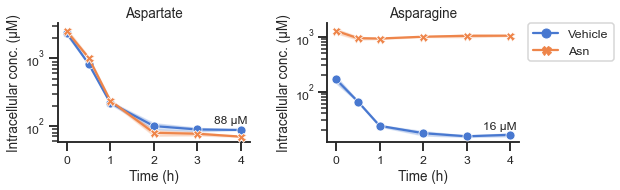

In [22]:
# Plot relevant ratios:

sns.set_context("talk", font_scale=0.75)


Nmetab = 2
metab_lst = ['Aspartate conc', 'Asparagine conc']
fig, axes = plt.subplots(1, Nmetab, figsize=(4.6*Nmetab, 3.2))
mi = 1
for metab_name, ax in zip(metab_lst, axes):
    g1 = sns.lineplot(ax=ax, data=df_v2, x='Time', y=metab_name, hue='Rescue', style='Rescue', markers=True, dashes=False, zorder=10)
    if mi < Nmetab:
        g1.legend_.remove()
        mi += 1
    else:
        g1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
    g1.set_xlabel('Time (h)')
    g1.set_ylabel('Intracellular conc. (μM)')
    g1.set(yscale="log")
    g1.set_title(metab_name[:-5])

    if metab_name == 'Aspartate conc':
        conc = df_v2[df_v2['Rescue']=='Vehicle']['Aspartate conc'].values[-2:].mean()
        g1.text(4.15, conc*1.25, '{} μM'.format(round(conc)), ha='right', size=12)
    elif metab_name == 'Asparagine conc':
        conc = df_v2[df_v2['Rescue']=='Vehicle']['Asparagine conc'].values[-2:].mean()
        g1.text(4.15, conc*1.25, '{} μM'.format(round(conc)), ha='right', size=12)


    sns.despine()



fig.tight_layout(pad=2)
fig.savefig('plots/pathway_plots/{}.pdf'.format('Asp_Asn'), bbox_inches='tight')
